In [2]:
#!/usr/bin/env python3
"""
GRAMPA数据集预处理脚本
根据筛选器设计.md的要求进行数据清洗与标准化
"""

import pandas as pd
import numpy as np
import os
import re
from collections import Counter
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

class GRAMPAPreprocessor:
    def __init__(self, input_file, output_dir='processed_data'):
        self.input_file = input_file
        self.output_dir = output_dir
        self.df = None
        self.processed_df = None
        
        # 创建输出目录
        os.makedirs(output_dir, exist_ok=True)
        
        # 标准氨基酸字母表
        self.standard_aa = set('ACDEFGHIKLMNPQRSTVWY')
        
        # 菌株名称标准化映射
        self.bacteria_mapping = {
            'escherichia coli': 'escherichia_coli',
            'e. coli': 'escherichia_coli',
            'e.coli': 'escherichia_coli',
            'staphylococcus aureus': 'staphylococcus_aureus',
            'staph. aureus': 'staphylococcus_aureus',
            's. aureus': 'staphylococcus_aureus',
            's.aureus': 'staphylococcus_aureus',
            'pseudomonas aeruginosa': 'pseudomonas_aeruginosa',
            'p. aeruginosa': 'pseudomonas_aeruginosa',
            'p.aeruginosa': 'pseudomonas_aeruginosa',
            'klebsiella pneumoniae': 'klebsiella_pneumoniae',
            'k. pneumoniae': 'klebsiella_pneumoniae',
            'k.pneumoniae': 'klebsiella_pneumoniae',
            'candida albicans': 'candida_albicans',
            'c. albicans': 'candida_albicans',
            'c.albicans': 'candida_albicans',
            'bacillus subtilis': 'bacillus_subtilis',
            'b. subtilis': 'bacillus_subtilis',
            'enterococcus faecalis': 'enterococcus_faecalis',
            'e. faecalis': 'enterococcus_faecalis',
            'streptococcus pyogenes': 'streptococcus_pyogenes',
            's. pyogenes': 'streptococcus_pyogenes',
        }
    
    def load_data(self):
        """加载数据并进行基本分析"""
        print("正在加载数据...")
        self.df = pd.read_csv(self.input_file)
        
        print(f"数据集形状: {self.df.shape}")
        print(f"列名: {self.df.columns.tolist()}")
        print(f"缺失值统计:")
        print(self.df.isnull().sum())
        print(f"\n数据类型:")
        print(self.df.dtypes)
        print(f"\nvalue字段统计:")
        print(self.df['value'].describe())
        print(f"\ncensor字段统计:")
        print(self.df['censor'].value_counts(dropna=False))
        
        return self.df
    
    def normalize_sequence(self, sequence):
        """序列合法化处理"""
        if pd.isna(sequence):
            return None, 1.0  # 返回序列和X占比
            
        # 转为大写
        seq = str(sequence).upper().strip()
        
        # 移除非字母字符（空格、标点等）
        seq = re.sub(r'[^A-Z]', '', seq)
        
        if len(seq) == 0:
            return None, 1.0
            
        # 将非标准氨基酸映射为X
        normalized_seq = ''
        for aa in seq:
            if aa in self.standard_aa:
                normalized_seq += aa
            else:
                normalized_seq += 'X'
        
        # 计算X占比
        x_ratio = normalized_seq.count('X') / len(normalized_seq) if len(normalized_seq) > 0 else 1.0
        
        return normalized_seq, x_ratio
    
    def normalize_bacterium(self, bacterium_name):
        """菌株名称标准化"""
        if pd.isna(bacterium_name):
            return 'unknown'
            
        name = str(bacterium_name).lower().strip()
        
        # 移除株系信息（括号内容、数字、特殊符号等）
        name = re.sub(r'\([^)]*\)', '', name)  # 移除括号内容
        name = re.sub(r'\s+\d+.*$', '', name)  # 移除数字及后续内容
        name = re.sub(r'\s+strain.*$', '', name, flags=re.IGNORECASE)  # 移除strain信息
        name = re.sub(r'\s+atcc.*$', '', name, flags=re.IGNORECASE)  # 移除ATCC信息
        name = name.strip()
        
        # 标准化映射
        if name in self.bacteria_mapping:
            return self.bacteria_mapping[name]
        
        # 对于未映射的，保留属种名
        parts = name.split()
        if len(parts) >= 2:
            genus_species = f"{parts[0]}_{parts[1]}"
            return genus_species.replace(' ', '_').replace('-', '_')
        
        return name.replace(' ', '_').replace('-', '_')
    
    def sequence_cleaning(self):
        """步骤1: 序列合法化"""
        print("\n=== 步骤1: 序列合法化 ===")
        
        # 处理序列
        seq_info = self.df['sequence'].apply(self.normalize_sequence)
        self.df['normalized_sequence'] = [x[0] for x in seq_info]
        self.df['x_ratio'] = [x[1] for x in seq_info]
        
        # 统计
        print(f"原始样本数: {len(self.df)}")
        
        # 移除空序列
        valid_seq_mask = self.df['normalized_sequence'].notna()
        print(f"空序列样本数: {(~valid_seq_mask).sum()}")
        
        # 移除X占比>10%的序列
        x_ratio_mask = self.df['x_ratio'] <= 0.1
        print(f"X占比>10%的样本数: {(~x_ratio_mask).sum()}")
        
        # 长度筛选
        self.df['seq_length'] = self.df['normalized_sequence'].fillna('').str.len()
        length_5_48_mask = (self.df['seq_length'] >= 5) & (self.df['seq_length'] <= 48)
        length_lt5_mask = (self.df['seq_length'] > 0) & (self.df['seq_length'] < 5)
        length_gt48_mask = self.df['seq_length'] > 48
        
        print(f"长度<5的样本数: {length_lt5_mask.sum()}")
        print(f"长度5-48的样本数: {length_5_48_mask.sum()}")
        print(f"长度>48的样本数: {length_gt48_mask.sum()}")
        
        # 主训练集：5-48 aa，X占比<=10%
        main_mask = valid_seq_mask & x_ratio_mask & length_5_48_mask
        self.df['dataset_split'] = 'exclude'
        self.df.loc[main_mask, 'dataset_split'] = 'main'
        self.df.loc[valid_seq_mask & x_ratio_mask & length_lt5_mask, 'dataset_split'] = 'short'
        self.df.loc[valid_seq_mask & x_ratio_mask & length_gt48_mask, 'dataset_split'] = 'long'
        
        print(f"主训练集样本数: {main_mask.sum()}")
        print(f"短肽样本数: {(self.df['dataset_split'] == 'short').sum()}")
        print(f"长肽样本数: {(self.df['dataset_split'] == 'long').sum()}")
        print(f"排除样本数: {(self.df['dataset_split'] == 'exclude').sum()}")
        
        return self.df
    
    def bacteria_normalization(self):
        """步骤2: 菌株归一化"""
        print("\n=== 步骤2: 菌株归一化 ===")
        
        # 标准化菌株名
        self.df['normalized_bacterium'] = self.df['bacterium'].apply(self.normalize_bacterium)
        
        # 统计菌株频次
        bacteria_counts = self.df['normalized_bacterium'].value_counts()
        print(f"唯一菌株数: {len(bacteria_counts)}")
        print(f"Top 10菌株:")
        print(bacteria_counts.head(10))
        
        # 长尾菌株处理（频次<10的归为other）
        low_freq_bacteria = bacteria_counts[bacteria_counts < 10].index
        print(f"低频菌株数（<10次）: {len(low_freq_bacteria)}")
        
        self.df['final_bacterium'] = self.df['normalized_bacterium'].copy()
        self.df.loc[self.df['normalized_bacterium'].isin(low_freq_bacteria), 'final_bacterium'] = 'other'
        
        final_bacteria_counts = self.df['final_bacterium'].value_counts()
        print(f"最终菌株数: {len(final_bacteria_counts)}")
        print(f"归为other的样本数: {(self.df['final_bacterium'] == 'other').sum()}")
        
        return self.df
    
    def handle_duplicates(self):
        """步骤3: 重复测定处理"""
        print("\n=== 步骤3: 重复测定处理 ===")
        
        # 只处理主训练集
        main_df = self.df[self.df['dataset_split'] == 'main'].copy()
        
        # 统计重复情况
        duplicate_groups = main_df.groupby(['normalized_sequence', 'final_bacterium'])
        duplicate_stats = duplicate_groups.size()
        
        print(f"唯一(sequence, bacterium)对数: {len(duplicate_stats)}")
        print(f"重复测定统计:")
        print(duplicate_stats.value_counts().sort_index())
        print(f"最大重复次数: {duplicate_stats.max()}")
        
        # 对每个(sequence, bacterium)组合计算几何均值
        def geometric_mean_log(values):
            """对log值计算几何均值（先转回原值，算几何均值，再取log）"""
            # value是log10(uM)，需要转回uM
            original_values = 10 ** values
            # 计算几何均值
            geom_mean = np.exp(np.mean(np.log(original_values)))
            # 转回log10
            return np.log10(geom_mean)
        
        aggregated_data = []
        for (seq, bact), group in duplicate_groups:
            values = group['value'].values
            n_measurements = len(values)
            
            # 删失信息处理 - 改进版
            censor_info = group['censor'].fillna('').values
            censored_mask = censor_info == '>'
            has_censoring = censored_mask.any()
            
            # 计算聚合值
            if has_censoring:
                # 有删失的情况：分别处理删失和非删失值
                censored_values = values[censored_mask]
                uncensored_values = values[~censored_mask]
                
                # 删失阈值：删失样本中的最大值作为下界约束
                censoring_threshold = censored_values.max() if len(censored_values) > 0 else None
                
                # 聚合值：只用非删失值计算几何均值
                if len(uncensored_values) > 0:
                    agg_value = geometric_mean_log(uncensored_values)
                else:
                    # 全是删失值的情况，用删失阈值作为下界估计
                    agg_value = censoring_threshold
                    
                # 标准差：只用非删失值
                value_std = np.std(uncensored_values) if len(uncensored_values) > 1 else 0.0
                
            else:
                # 无删失的情况：正常处理
                agg_value = geometric_mean_log(values)
                value_std = np.std(values)
                censoring_threshold = None
            
            # 其他信息
            database = group['database'].iloc[0]
            unit = group['unit'].iloc[0]
            seq_length = group['seq_length'].iloc[0]
            x_ratio = group['x_ratio'].iloc[0]
            
            aggregated_data.append({
                'sequence': seq,
                'bacterium': bact,
                'value': agg_value,
                'n_measurements': n_measurements,
                'n_censored': censored_mask.sum(),
                'n_uncensored': (~censored_mask).sum(),
                'value_std': value_std,
                'has_censoring': has_censoring,
                'censoring_threshold': censoring_threshold,  # 删失下界约束
                'unit': unit,
                'database': database,
                'seq_length': seq_length,
                'x_ratio': x_ratio
            })
        
        self.aggregated_df = pd.DataFrame(aggregated_data)
        print(f"聚合后样本数: {len(self.aggregated_df)}")
        print(f"平均重复测定次数: {self.aggregated_df['n_measurements'].mean():.2f}")
        print(f"删失样本数: {self.aggregated_df['has_censoring'].sum()}")
        print(f"完全删失样本数: {(self.aggregated_df['n_uncensored'] == 0).sum()}")
        
        return self.aggregated_df
    
    def handle_censoring(self):
        """步骤4: 删失样本处理 - 改进版"""
        print("\n=== 步骤4: 删失样本处理（改进版） ===")
        
        censored_count = self.aggregated_df['has_censoring'].sum()
        fully_censored_count = (self.aggregated_df['n_uncensored'] == 0).sum()
        
        print(f"包含删失信息的样本数: {censored_count}")
        print(f"完全删失样本数: {fully_censored_count}")
        print(f"删失样本占比: {censored_count / len(self.aggregated_df) * 100:.2f}%")
        
        # 删失信息统计
        if censored_count > 0:
            censored_df = self.aggregated_df[self.aggregated_df['has_censoring']]
            print(f"删失阈值分布:")
            print(f"  - 最小删失阈值: {censored_df['censoring_threshold'].min():.3f}")
            print(f"  - 最大删失阈值: {censored_df['censoring_threshold'].max():.3f}")
            print(f"  - 平均删失阈值: {censored_df['censoring_threshold'].mean():.3f}")
            
            # 检查删失一致性：聚合值不应低于删失阈值
            inconsistent_mask = censored_df['value'] < censored_df['censoring_threshold']
            inconsistent_count = inconsistent_mask.sum()
            if inconsistent_count > 0:
                print(f"警告: {inconsistent_count}个样本的聚合值低于删失阈值（数据不一致）")
        
        # 为损失函数准备删失标记
        self.aggregated_df['is_censored'] = self.aggregated_df['has_censoring']
        
        return self.aggregated_df
    
    def winsorize_values(self, percentile_range=(1, 99)):
        """步骤5: 异常值稳健化"""
        print("\n=== 步骤5: 异常值稳健化 ===")
        
        values = self.aggregated_df['value']
        
        # 计算分位数
        p_low = np.percentile(values, percentile_range[0])
        p_high = np.percentile(values, percentile_range[1])
        
        print(f"原始value范围: [{values.min():.3f}, {values.max():.3f}]")
        print(f"Winsorize范围 ({percentile_range[0]}%-{percentile_range[1]}%): [{p_low:.3f}, {p_high:.3f}]")
        
        # Winsorize处理
        winsorized_values = np.clip(values, p_low, p_high)
        
        # 统计影响的样本数
        affected_low = (values < p_low).sum()
        affected_high = (values > p_high).sum()
        print(f"被调整的样本数: 低端{affected_low}个, 高端{affected_high}个")
        
        self.aggregated_df['value_winsorized'] = winsorized_values
        self.aggregated_df['value_original'] = values
        
        return self.aggregated_df
    
    def create_sequence_aggregated_dataset(self):
        """创建序列聚合数据集（用于模型A）"""
        print("\n=== 创建序列聚合数据集 ===")
        
        # 按序列聚合，计算所有菌株的平均活性
        seq_groups = self.aggregated_df.groupby('sequence')
        
        seq_aggregated_data = []
        for seq, group in seq_groups:
            # 使用winsorized值计算均值
            mean_value = group['value_winsorized'].mean()
            std_value = group['value_winsorized'].std()
            n_bacteria = len(group)
            total_measurements = group['n_measurements'].sum()
            
            # 序列特征
            seq_length = group['seq_length'].iloc[0]
            x_ratio = group['x_ratio'].iloc[0]
            
            # 删失信息
            has_any_censoring = group['has_censoring'].any()
            
            seq_aggregated_data.append({
                'sequence': seq,
                'mean_log_mic': mean_value,
                'std_log_mic': std_value,
                'n_bacteria_tested': n_bacteria,
                'total_measurements': total_measurements,
                'seq_length': seq_length,
                'x_ratio': x_ratio,
                'has_censoring': has_any_censoring
            })
        
        self.seq_aggregated_df = pd.DataFrame(seq_aggregated_data)
        print(f"序列聚合数据集样本数: {len(self.seq_aggregated_df)}")
        
        return self.seq_aggregated_df
    
    def create_stratified_bacteria_splits(self):
        """创建按菌株分层的序列分组"""
        # 为每个序列计算主要菌株（出现最多的菌株）
        seq_bacteria_mapping = {}
        for seq in self.aggregated_df['sequence'].unique():
            seq_data = self.aggregated_df[self.aggregated_df['sequence'] == seq]
            main_bacterium = seq_data['bacterium'].value_counts().index[0]
            seq_bacteria_mapping[seq] = main_bacterium
        
        return seq_bacteria_mapping
    
    def create_train_val_test_splits(self, n_splits=5, test_size=0.2, val_size=0.1):
        """步骤6: 创建数据划分 - 改进版使用真正的GroupKFold"""
        print("\n=== 步骤6: 数据划分（改进版GroupKFold） ===")
        
        # 准备序列级数据用于划分
        sequences = self.aggregated_df['sequence'].unique()
        print(f"唯一序列数: {len(sequences)}")
        
        # 创建序列-主要菌株映射，用于分层
        seq_bacteria_mapping = self.create_stratified_bacteria_splits()
        
        # 统计每个菌株的序列数
        bacteria_seq_counts = pd.Series(seq_bacteria_mapping.values()).value_counts()
        print(f"各菌株的序列数分布 (Top 10):")
        print(bacteria_seq_counts.head(10))
        
        # 为了保证菌株分布平衡，我们使用分层策略
        # 首先按菌株频次分组
        high_freq_bacteria = bacteria_seq_counts[bacteria_seq_counts >= 50].index  # 高频菌株
        medium_freq_bacteria = bacteria_seq_counts[(bacteria_seq_counts >= 10) & (bacteria_seq_counts < 50)].index
        low_freq_bacteria = bacteria_seq_counts[bacteria_seq_counts < 10].index
        
        print(f"高频菌株数 (>=50序列): {len(high_freq_bacteria)}")
        print(f"中频菌株数 (10-49序列): {len(medium_freq_bacteria)}")  
        print(f"低频菌株数 (<10序列): {len(low_freq_bacteria)}")
        
        # 分别对每个频次组使用GroupKFold
        def stratified_group_split(sequences, bacteria_mapping, test_size, val_size, random_state=42):
            """按菌株分层的GroupKFold划分"""
            np.random.seed(random_state)
            
            # 按菌株分组序列
            bacteria_sequences = {}
            for seq, bacterium in bacteria_mapping.items():
                if bacterium not in bacteria_sequences:
                    bacteria_sequences[bacterium] = []
                bacteria_sequences[bacterium].append(seq)
            
            train_seqs, val_seqs, test_seqs = [], [], []
            
            # 对每个菌株的序列进行划分
            for bacterium, seqs in bacteria_sequences.items():
                seqs = np.array(seqs)
                n_seqs = len(seqs)
                
                if n_seqs == 1:
                    # 只有1个序列，随机分配
                    split_choice = np.random.choice(['train', 'val', 'test'], p=[1-test_size-val_size, val_size, test_size])
                    if split_choice == 'train':
                        train_seqs.extend(seqs)
                    elif split_choice == 'val':
                        val_seqs.extend(seqs)
                    else:
                        test_seqs.extend(seqs)
                elif n_seqs == 2:
                    # 2个序列，一个给train，一个随机分配给val或test
                    train_seqs.append(seqs[0])
                    split_choice = np.random.choice(['val', 'test'])
                    if split_choice == 'val':
                        val_seqs.append(seqs[1])
                    else:
                        test_seqs.append(seqs[1])
                else:
                    # 多个序列，按比例划分
                    shuffled = np.random.permutation(seqs)
                    n_test = max(1, int(n_seqs * test_size))
                    n_val = max(1, int(n_seqs * val_size))
                    n_train = n_seqs - n_test - n_val
                    
                    if n_train < 1:  # 确保至少有1个训练样本
                        n_train = 1
                        n_test = max(1, n_seqs - n_train - n_val)
                        n_val = n_seqs - n_train - n_test
                    
                    train_seqs.extend(shuffled[:n_train])
                    val_seqs.extend(shuffled[n_train:n_train+n_val])
                    test_seqs.extend(shuffled[n_train+n_val:])
            
            return set(train_seqs), set(val_seqs), set(test_seqs)
        
        # 执行分层划分
        train_sequences, val_sequences, test_sequences = stratified_group_split(
            sequences, seq_bacteria_mapping, test_size, val_size
        )
        
        print(f"训练集序列数: {len(train_sequences)}")
        print(f"验证集序列数: {len(val_sequences)}")
        print(f"测试集序列数: {len(test_sequences)}")
        
        # 验证没有重叠
        assert len(train_sequences & val_sequences) == 0, "训练集和验证集有重叠序列"
        assert len(train_sequences & test_sequences) == 0, "训练集和测试集有重叠序列"
        assert len(val_sequences & test_sequences) == 0, "验证集和测试集有重叠序列"
        
        # 为聚合数据集添加split标记
        def assign_split(seq):
            if seq in train_sequences:
                return 'train'
            elif seq in val_sequences:
                return 'val'
            else:
                return 'test'
        
        self.aggregated_df['split'] = self.aggregated_df['sequence'].apply(assign_split)
        self.seq_aggregated_df['split'] = self.seq_aggregated_df['sequence'].apply(assign_split)
        
        # 统计每个split的样本数和菌株分布
        split_stats = self.aggregated_df.groupby('split').agg({
            'sequence': 'count',
            'bacterium': 'nunique',
            'value_winsorized': ['mean', 'std']
        }).round(3)
        
        print(f"各split统计:")
        print(split_stats)
        
        # 检查菌株分布平衡性
        print(f"\n各split菌株分布平衡性检查:")
        for split in ['train', 'val', 'test']:
            split_bacteria = self.aggregated_df[self.aggregated_df['split'] == split]['bacterium'].value_counts()
            print(f"{split}集 Top 5菌株: {dict(split_bacteria.head(5))}")
        
        return train_sequences, val_sequences, test_sequences
    
    def save_processed_datasets(self):
        """保存处理后的数据集"""
        print("\n=== 保存数据集 ===")
        
        # 保存完整的聚合数据集
        output_file = os.path.join(self.output_dir, 'grampa_aggregated_full.csv')
        self.aggregated_df.to_csv(output_file, index=False)
        print(f"完整聚合数据集已保存: {output_file}")
        
        # 保存序列聚合数据集
        seq_output_file = os.path.join(self.output_dir, 'grampa_sequence_aggregated.csv')
        self.seq_aggregated_df.to_csv(seq_output_file, index=False)
        print(f"序列聚合数据集已保存: {seq_output_file}")
        
        # 按split保存
        for split in ['train', 'val', 'test']:
            # 条件回归数据集（包含菌株信息）
            split_df = self.aggregated_df[self.aggregated_df['split'] == split].copy()
            split_file = os.path.join(self.output_dir, f'grampa_conditional_{split}.csv')
            split_df.to_csv(split_file, index=False)
            print(f"{split}集（条件回归）已保存: {split_file} ({len(split_df)} 样本)")
            
            # 序列回归数据集
            seq_split_df = self.seq_aggregated_df[self.seq_aggregated_df['split'] == split].copy()
            seq_split_file = os.path.join(self.output_dir, f'grampa_sequence_{split}.csv')
            seq_split_df.to_csv(seq_split_file, index=False)
            print(f"{split}集（序列回归）已保存: {seq_split_file} ({len(seq_split_df)} 样本)")
        
        # 保存其他长度的数据集
        other_splits = self.df[self.df['dataset_split'].isin(['short', 'long'])].copy()
        if len(other_splits) > 0:
            other_file = os.path.join(self.output_dir, 'grampa_other_lengths.csv')
            other_splits.to_csv(other_file, index=False)
            print(f"其他长度数据集已保存: {other_file} ({len(other_splits)} 样本)")
        
        # 保存处理报告
        self.save_processing_report()
    
    def save_processing_report(self):
        """保存处理报告"""
        report_file = os.path.join(self.output_dir, 'processing_report.md')
        
        with open(report_file, 'w', encoding='utf-8') as f:
            f.write("# GRAMPA数据集处理报告\n\n")
            
            f.write("## 原始数据统计\n")
            f.write(f"- 原始样本数: {len(self.df)}\n")
            f.write(f"- 唯一序列数: {self.df['normalized_sequence'].nunique()}\n")
            f.write(f"- 唯一菌株数: {self.df['normalized_bacterium'].nunique()}\n\n")
            
            f.write("## 序列长度分布\n")
            length_dist = self.df['dataset_split'].value_counts()
            for category, count in length_dist.items():
                f.write(f"- {category}: {count}\n")
            f.write("\n")
            
            f.write("## 聚合后数据统计\n")
            f.write(f"- 聚合样本数: {len(self.aggregated_df)}\n")
            f.write(f"- 序列聚合样本数: {len(self.seq_aggregated_df)}\n")
            f.write(f"- 平均重复测定次数: {self.aggregated_df['n_measurements'].mean():.2f}\n")
            f.write(f"- 删失样本数: {self.aggregated_df['has_censoring'].sum()}\n")
            f.write(f"- 完全删失样本数: {(self.aggregated_df['n_uncensored'] == 0).sum()}\n\n")
            
            f.write("## 数据划分统计\n")
            split_stats = self.aggregated_df['split'].value_counts()
            for split, count in split_stats.items():
                f.write(f"- {split}: {count}\n")
            f.write("\n")
            
            f.write("## Value分布统计\n")
            f.write(f"- 原始范围: [{self.aggregated_df['value_original'].min():.3f}, {self.aggregated_df['value_original'].max():.3f}]\n")
            f.write(f"- Winsorized范围: [{self.aggregated_df['value_winsorized'].min():.3f}, {self.aggregated_df['value_winsorized'].max():.3f}]\n")
            f.write(f"- 均值: {self.aggregated_df['value_winsorized'].mean():.3f}\n")
            f.write(f"- 标准差: {self.aggregated_df['value_winsorized'].std():.3f}\n\n")
            
            f.write("## 菌株分布（Top 10）\n")
            bacteria_counts = self.aggregated_df['bacterium'].value_counts().head(10)
            for bacterium, count in bacteria_counts.items():
                f.write(f"- {bacterium}: {count}\n")
        
        print(f"处理报告已保存: {report_file}")
    
    def run_full_pipeline(self):
        """运行完整的预处理流程"""
        print("开始GRAMPA数据集预处理流程...")
        
        # 加载数据
        self.load_data()
        
        # 步骤1: 序列合法化
        self.sequence_cleaning()
        
        # 步骤2: 菌株归一化
        self.bacteria_normalization()
        
        # 步骤3: 重复测定处理
        self.handle_duplicates()
        
        # 步骤4: 删失样本处理
        self.handle_censoring()
        
        # 步骤5: 异常值稳健化
        self.winsorize_values()
        
        # 创建序列聚合数据集
        self.create_sequence_aggregated_dataset()
        
        # 步骤6: 数据划分
        self.create_train_val_test_splits()
        
        # 保存所有数据集
        self.save_processed_datasets()
        
        print("\n数据预处理完成！")
        print(f"所有文件已保存到: {self.output_dir}")

def main():
    # 配置参数
    input_file = "/root/NKU-TMU_AMP_project/data/AMP/grampa_merged_dataset.csv"
    output_dir = "/root/NKU-TMU_AMP_project/processed_data"
    
    # 创建预处理器
    preprocessor = GRAMPAPreprocessor(input_file, output_dir)
    
    # 运行完整流程
    preprocessor.run_full_pipeline()

if __name__ == "__main__":
    main()


开始GRAMPA数据集预处理流程...
正在加载数据...
数据集形状: (44797, 6)
列名: ['bacterium', 'sequence', 'unit', 'value', 'censor', 'database']
缺失值统计:
bacterium       84
sequence         0
unit             0
value            0
censor       43932
database         0
dtype: int64

数据类型:
bacterium     object
sequence      object
unit          object
value        float64
censor        object
database      object
dtype: object

value字段统计:
count    44797.000000
mean         0.105690
std          0.539219
min         -3.558834
25%         -0.151399
50%          0.098738
75%          0.267724
max          3.657577
Name: value, dtype: float64

censor字段统计:
censor
NaN    43932
>        865
Name: count, dtype: int64

=== 步骤1: 序列合法化 ===
原始样本数: 44797
空序列样本数: 0
X占比>10%的样本数: 222
长度<5的样本数: 680
长度5-48的样本数: 42840
长度>48的样本数: 1277
主训练集样本数: 42626
短肽样本数: 672
长肽样本数: 1277
排除样本数: 222

=== 步骤2: 菌株归一化 ===
唯一菌株数: 1025
Top 10菌株:
normalized_bacterium
escherichia_coli              7795
staphylococcus_aureus         7329
pseudomonas_aeruginosa  

In [4]:
import os, pathlib, time

# ---- 放在任何 import 之前 ----
# 缓存/目录
os.environ["HF_HOME"] = "/root/autodl-tmp/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/root/autodl-tmp/huggingface/transformers"
pathlib.Path(os.environ["HF_HOME"]).mkdir(parents=True, exist_ok=True)
pathlib.Path(os.environ["TRANSFORMERS_CACHE"]).mkdir(parents=True, exist_ok=True)

# 代理
proxy = "http://127.0.0.1:7890"
for v in ["HTTP_PROXY","HTTPS_PROXY","http_proxy","https_proxy","ALL_PROXY"]:
    os.environ[v] = proxy

# --------------------------------
from huggingface_hub import snapshot_download

repo_id = "facebook/esm2_t33_650M_UR50D"
dest_dir = "/root/autodl-tmp/esm2_t33_650M_UR50D"
token = None  # 公开模型可 None；若需要私有库，填你的 token

retries, delay_s = 5, 15
last_err = None

for i in range(1, retries + 1):
    try:
        local_dir = snapshot_download(
            repo_id=repo_id,
            local_dir=dest_dir,
            local_dir_use_symlinks=False,   # 关键：写入真实文件到你指定硬盘
            resume_download=True,
            max_workers=4,                  # 网络稳定可开大一点
            etag_timeout=60,
            token=token
        )
        print(f"Model stored at: {local_dir}")
        last_err = None
        break
    except Exception as e:
        last_err = e
        print(f"[retry {i}/{retries}] {e}")
        time.sleep(delay_s)

if last_err:
    raise last_err


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

  2025-08-16T11:43:56.304458Z ERROR  error downloading range, error: ReqwestMiddlewareError(Reqwest(reqwest::Error { kind: Request, url: "https://transfer.xethub.hf.co/xorbs/default/43880025952904ce3c6d2219670148db97493638d0f6326494c00d9db901405f?X-Xet-Signed-Range=bytes%3D40035151-44433683&Expires=1755348175&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC80Mzg4MDAyNTk1MjkwNGNlM2M2ZDIyMTk2NzAxNDhkYjk3NDkzNjM4ZDBmNjMyNjQ5NGMwMGQ5ZGI5MDE0MDVmP1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDQwMDM1MTUxLTQ0NDMzNjgzIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNzU1MzQ4MTc1fX19XX0_&Signature=DkgiGkjHiZblmYANVjUfJxhe76~Q1lnoRkrjuyiJLqEFs49xMwfOdDUfP87o9seRXRo0fYtp-bzYj6sQbmCoFK0vpJIx5cOGk3vbnQteLyeVqh6lI9vviHMGw2Ewb4ULnYbzhE8nKzQw038gK4QHJxcxPNgM2jsMdVouKDMGT-BSyxXJZAwXMa8RU0avMAWypNDt4wFKfrszV48455QNPUDj6LHTdffFgDS0DDragJY2POgxgXSQf915-uqP0IZT4bkzpghXUe1lBfHPdxdjDepnM8jSJZDTjDtqVob29sqDXngyABf8LhL76UZdrk11YJAFUF7xX~~Bd2WCVmFKJQ__&Ke

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Model stored at: /root/autodl-tmp/esm2_t33_650M_UR50D


In [6]:
#!/usr/bin/env python3
"""
特征构建脚本
实现PLM表征、理化特征和菌株表示的生成
基于筛选器设计.md的第三部分要求
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import EsmTokenizer, EsmModel
import os
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 理化特征计算
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import math

class AMP_FeatureExtractor:
    def __init__(self, 
                 processed_data_dir='processed_data',
                 features_output_dir='features',
                 esm_model_name='facebook/esm2_t33_650M_UR50D',
                 device='auto'):
        """
        初始化特征提取器
        
        Args:
            processed_data_dir: 处理后数据目录
            features_output_dir: 特征输出目录
            esm_model_name: ESM模型名称
            device: 计算设备
        """
        self.processed_data_dir = processed_data_dir
        self.features_output_dir = features_output_dir
        self.esm_model_name = esm_model_name
        
        # 设备配置
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        print(f"使用设备: {self.device}")
        
        # 创建输出目录
        os.makedirs(features_output_dir, exist_ok=True)
        
        # 初始化ESM模型和tokenizer
        print("正在加载ESM-2模型...")
        local_dir = "/root/autodl-tmp/esm2_t33_650M_UR50D"
        self.tokenizer = EsmTokenizer.from_pretrained(local_dir, local_files_only=True)
        self.esm_model = EsmModel.from_pretrained(local_dir, local_files_only=True).to(self.device)
        self.esm_model.eval()
        print("ESM-2模型加载完成")
        
        # 氨基酸属性字典
        self.aa_properties = {
            # 疏水性 (Kyte-Doolittle scale)
            'hydrophobicity': {
                'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
            },
            # 电荷 (pH 7.4)
            'charge': {
                'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0,
                'Q': 0, 'E': -1, 'G': 0, 'H': 0, 'I': 0,
                'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
                'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0
            },
            # 极性
            'polarity': {
                'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 0,
                'Q': 1, 'E': 1, 'G': 0, 'H': 1, 'I': 0,
                'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
                'S': 1, 'T': 1, 'W': 0, 'Y': 1, 'V': 0
            }
        }
    
    def extract_plm_embeddings(self, sequences, batch_size=32, max_length=512):
        """
        提取PLM (ESM-2) 表征
        
        Args:
            sequences: 序列列表
            batch_size: 批次大小
            max_length: 最大序列长度
            
        Returns:
            embeddings: shape (n_sequences, 2*hidden_dim) 的embedding矩阵
        """
        print(f"正在提取 {len(sequences)} 个序列的PLM embeddings...")
        
        all_embeddings = []
        
        # 批次处理
        for i in tqdm(range(0, len(sequences), batch_size), desc="提取PLM embeddings"):
            batch_sequences = sequences[i:i+batch_size]
            
            # 过滤掉过长的序列
            valid_sequences = []
            valid_indices = []
            for j, seq in enumerate(batch_sequences):
                if len(seq) <= max_length:
                    valid_sequences.append(seq)
                    valid_indices.append(j)
            
            if not valid_sequences:
                # 如果批次中没有有效序列，添加零向量
                batch_embeddings = torch.zeros(len(batch_sequences), 2 * self.esm_model.config.hidden_size)
                all_embeddings.append(batch_embeddings)
                continue
            
            # Tokenize
            inputs = self.tokenizer(
                valid_sequences, 
                return_tensors="pt", 
                padding=True, 
                truncation=True,
                max_length=max_length
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.esm_model(**inputs)
                # 获取序列表征 (去除CLS和SEP tokens)
                sequence_embeddings = outputs.last_hidden_state[:, 1:-1, :]  # (batch, seq_len, hidden_dim)
                
                # 池化操作
                mean_pooled = torch.mean(sequence_embeddings, dim=1)  # (batch, hidden_dim)
                max_pooled = torch.max(sequence_embeddings, dim=1)[0]  # (batch, hidden_dim)
                
                # 拼接均值和最大池化
                combined_embeddings = torch.cat([mean_pooled, max_pooled], dim=1)  # (batch, 2*hidden_dim)
                
                # 创建完整批次的embedding矩阵
                batch_embeddings = torch.zeros(len(batch_sequences), 2 * self.esm_model.config.hidden_size)
                for j, valid_idx in enumerate(valid_indices):
                    batch_embeddings[valid_idx] = combined_embeddings[j].cpu()
                
                all_embeddings.append(batch_embeddings)
        
        # 合并所有批次
        final_embeddings = torch.cat(all_embeddings, dim=0)
        print(f"PLM embeddings shape: {final_embeddings.shape}")
        
        return final_embeddings.numpy()
    
    def calculate_physicochemical_features(self, sequences):
        """
        计算理化特征
        
        Args:
            sequences: 序列列表
            
        Returns:
            features: 理化特征矩阵
        """
        print(f"正在计算 {len(sequences)} 个序列的理化特征...")
        
        features = []
        
        for seq in tqdm(sequences, desc="计算理化特征"):
            seq_features = {}
            
            # 处理无效序列
            if not seq or pd.isna(seq) or len(seq) == 0:
                # 返回零特征
                features.append([0] * 30)  # 预计30个特征
                continue
            
            # 清理序列（移除非标准氨基酸）
            clean_seq = ''.join([aa for aa in seq.upper() if aa in 'ACDEFGHIKLMNPQRSTVWY'])
            if len(clean_seq) == 0:
                features.append([0] * 30)
                continue
            
            try:
                # 使用BioPython计算基本特征
                analysis = ProteinAnalysis(clean_seq)
                
                # 1. 长度
                length = len(clean_seq)
                
                # 2. 分子量
                mw = analysis.molecular_weight()
                
                # 3. 等电点
                try:
                    isoelectric_point = analysis.isoelectric_point()
                except:
                    isoelectric_point = 7.0
                
                # 4. GRAVY (疏水性)
                try:
                    gravy = analysis.gravy()
                except:
                    gravy = 0.0
                
                # 5. 净电荷 (pH 7.4)
                net_charge = sum([self.aa_properties['charge'].get(aa, 0) for aa in clean_seq])
                
                # 6. RK含量 (碱性残基比例)
                rk_count = clean_seq.count('R') + clean_seq.count('K')
                rk_ratio = rk_count / length if length > 0 else 0
                
                # 7. 氨基酸组成 (20维)
                aa_composition = []
                for aa in 'ACDEFGHIKLMNPQRSTVWY':
                    aa_composition.append(clean_seq.count(aa) / length if length > 0 else 0)
                
                # 8. 疏水矩 (假设α螺旋)
                hydrophobic_moment = self.calculate_hydrophobic_moment(clean_seq)
                
                # 9. 其他特征
                positive_charge = sum([1 for aa in clean_seq if self.aa_properties['charge'].get(aa, 0) > 0])
                negative_charge = sum([1 for aa in clean_seq if self.aa_properties['charge'].get(aa, 0) < 0])
                polar_residues = sum([1 for aa in clean_seq if self.aa_properties['polarity'].get(aa, 0) == 1])
                
                # 组装特征向量
                feature_vector = [
                    length,
                    mw,
                    isoelectric_point,
                    gravy,
                    net_charge,
                    rk_ratio,
                    hydrophobic_moment,
                    positive_charge / length if length > 0 else 0,
                    negative_charge / length if length > 0 else 0,
                    polar_residues / length if length > 0 else 0
                ] + aa_composition
                
                features.append(feature_vector)
                
            except Exception as e:
                print(f"计算序列 {seq[:20]}... 的理化特征时出错: {e}")
                features.append([0] * 30)
        
        features_array = np.array(features, dtype=np.float32)
        print(f"理化特征 shape: {features_array.shape}")
        
        return features_array
    
    def calculate_hydrophobic_moment(self, sequence, window=100):
        """
        计算疏水矩 (假设α螺旋结构)
        
        Args:
            sequence: 氨基酸序列
            window: 螺旋角度窗口 (度)
            
        Returns:
            hydrophobic_moment: 疏水矩值
        """
        if len(sequence) == 0:
            return 0.0
        
        # α螺旋每个残基旋转100度
        angle_per_residue = math.radians(window)
        
        sum_x = 0
        sum_y = 0
        
        for i, aa in enumerate(sequence):
            hydrophobicity = self.aa_properties['hydrophobicity'].get(aa, 0)
            angle = i * angle_per_residue
            
            sum_x += hydrophobicity * math.cos(angle)
            sum_y += hydrophobicity * math.sin(angle)
        
        hydrophobic_moment = math.sqrt(sum_x**2 + sum_y**2) / len(sequence)
        return hydrophobic_moment
    
    def create_bacteria_embeddings(self, bacteria_names, embedding_dim=32):
        """
        创建菌株embedding映射
        
        Args:
            bacteria_names: 菌株名称列表
            embedding_dim: embedding维度
            
        Returns:
            bacteria_to_id: 菌株名到ID的映射
            embedding_matrix: embedding矩阵
        """
        print(f"正在创建菌株embeddings...")
        
        # 统计菌株频次
        bacteria_counts = pd.Series(bacteria_names).value_counts()
        print(f"唯一菌株数: {len(bacteria_counts)}")
        
        # 创建菌株到ID的映射
        bacteria_to_id = {}
        id_to_bacteria = {}
        
        # 为常见菌株分配ID
        for i, (bacteria, count) in enumerate(bacteria_counts.items()):
            bacteria_to_id[bacteria] = i
            id_to_bacteria[i] = bacteria
        
        # 创建可学习的embedding矩阵
        n_bacteria = len(bacteria_to_id)
        embedding_matrix = np.random.normal(0, 0.1, (n_bacteria, embedding_dim)).astype(np.float32)
        
        print(f"菌株embedding shape: {embedding_matrix.shape}")
        
        return bacteria_to_id, embedding_matrix, id_to_bacteria
    
    def process_all_datasets(self):
        """
        处理所有数据集，生成特征
        """
        print("开始特征工程流程...")
        
        # 1. 加载处理后的数据
        datasets = {}
        for split in ['train', 'val', 'test']:
            # 条件回归数据集 (包含菌株信息)
            conditional_file = os.path.join(self.processed_data_dir, f'grampa_conditional_{split}.csv')
            if os.path.exists(conditional_file):
                try:
                    datasets[f'conditional_{split}'] = pd.read_csv(conditional_file, low_memory=False)
                    print(f"加载 {conditional_file}: {len(datasets[f'conditional_{split}'])} 样本")
                except Exception as e:
                    print(f"加载 {conditional_file} 失败: {e}")
                    continue
            
            # 序列回归数据集 (不含菌株信息)
            sequence_file = os.path.join(self.processed_data_dir, f'grampa_sequence_{split}.csv')
            if os.path.exists(sequence_file):
                try:
                    datasets[f'sequence_{split}'] = pd.read_csv(sequence_file, low_memory=False)
                    print(f"加载 {sequence_file}: {len(datasets[f'sequence_{split}'])} 样本")
                except Exception as e:
                    print(f"加载 {sequence_file} 失败: {e}")
                    continue
        
        # 2. 收集所有唯一序列
        all_sequences = set()
        for dataset_name, df in datasets.items():
            if 'sequence' in df.columns:
                all_sequences.update(df['sequence'].dropna().unique())
        
        all_sequences = sorted(list(all_sequences))
        print(f"总共 {len(all_sequences)} 个唯一序列")
        
        # 3. 提取PLM embeddings
        print("\n=== 提取PLM embeddings ===")
        plm_embeddings = self.extract_plm_embeddings(all_sequences)
        
        # 创建序列到embedding的映射
        seq_to_embedding = {seq: plm_embeddings[i] for i, seq in enumerate(all_sequences)}
        
        # 4. 计算理化特征
        print("\n=== 计算理化特征 ===")
        physicochemical_features = self.calculate_physicochemical_features(all_sequences)
        
        # 创建序列到理化特征的映射
        seq_to_physchem = {seq: physicochemical_features[i] for i, seq in enumerate(all_sequences)}
        
        # 5. 处理菌株embeddings (仅针对条件回归数据集)
        print("\n=== 创建菌株embeddings ===")
        all_bacteria = set()
        for dataset_name, df in datasets.items():
            if 'conditional' in dataset_name and 'bacterium' in df.columns:
                all_bacteria.update(df['bacterium'].dropna().unique())
        
        all_bacteria = sorted(list(all_bacteria))
        bacteria_to_id, bacteria_embedding_matrix, id_to_bacteria = self.create_bacteria_embeddings(all_bacteria)
        
        # 6. 为每个数据集生成特征
        print("\n=== 为各数据集生成特征 ===")
        for dataset_name, df in datasets.items():
            print(f"\n处理数据集: {dataset_name}")
            
            # 序列特征
            sequences = df['sequence'].values
            dataset_plm_embeddings = np.array([seq_to_embedding.get(seq, np.zeros(plm_embeddings.shape[1])) 
                                             for seq in sequences])
            dataset_physchem_features = np.array([seq_to_physchem.get(seq, np.zeros(physicochemical_features.shape[1])) 
                                                for seq in sequences])
            
            # 保存序列特征
            features_dict = {
                'plm_embeddings': dataset_plm_embeddings,
                'physicochemical_features': dataset_physchem_features,
                'sequences': sequences
            }
            
            # 如果是条件回归数据集，添加菌株信息
            if 'conditional' in dataset_name and 'bacterium' in df.columns:
                bacteria = df['bacterium'].values
                bacteria_ids = np.array([bacteria_to_id.get(bact, 0) for bact in bacteria])
                features_dict['bacteria_ids'] = bacteria_ids
                features_dict['bacteria_names'] = bacteria
            
            # 添加目标变量和其他信息
            if 'value_winsorized' in df.columns:
                features_dict['targets'] = df['value_winsorized'].values
            elif 'mean_log_mic' in df.columns:  # 序列聚合数据集的目标变量
                features_dict['targets'] = df['mean_log_mic'].values
            
            if 'is_censored' in df.columns:
                features_dict['is_censored'] = df['is_censored'].values
            if 'censoring_threshold' in df.columns:
                features_dict['censoring_threshold'] = df['censoring_threshold'].fillna(0).values
            if 'n_measurements' in df.columns:
                features_dict['sample_weights'] = df['n_measurements'].values
            elif 'total_measurements' in df.columns:  # 序列聚合数据集的权重
                features_dict['sample_weights'] = df['total_measurements'].values
            
            # 保存特征文件
            output_file = os.path.join(self.features_output_dir, f'{dataset_name}_features.pkl')
            with open(output_file, 'wb') as f:
                pickle.dump(features_dict, f)
            print(f"保存特征文件: {output_file}")
            print(f"  - PLM embeddings: {dataset_plm_embeddings.shape}")
            print(f"  - 理化特征: {dataset_physchem_features.shape}")
            if 'bacteria_ids' in features_dict:
                print(f"  - 菌株IDs: {features_dict['bacteria_ids'].shape}")
        
        # 7. 保存全局映射和embedding矩阵
        print("\n=== 保存全局映射 ===")
        
        # 保存序列特征映射
        seq_features_mapping = {
            'seq_to_plm': seq_to_embedding,
            'seq_to_physchem': seq_to_physchem,
            'plm_embedding_dim': plm_embeddings.shape[1],
            'physchem_feature_dim': physicochemical_features.shape[1]
        }
        
        with open(os.path.join(self.features_output_dir, 'sequence_features_mapping.pkl'), 'wb') as f:
            pickle.dump(seq_features_mapping, f)
        
        # 保存菌株映射和embedding
        bacteria_mapping = {
            'bacteria_to_id': bacteria_to_id,
            'id_to_bacteria': id_to_bacteria,
            'bacteria_embedding_matrix': bacteria_embedding_matrix,
            'embedding_dim': bacteria_embedding_matrix.shape[1]
        }
        
        with open(os.path.join(self.features_output_dir, 'bacteria_mapping.pkl'), 'wb') as f:
            pickle.dump(bacteria_mapping, f)
        
        print(f"\n特征工程完成！所有文件保存在: {self.features_output_dir}")
        
        # 8. 生成特征工程报告
        self.generate_feature_report(datasets, seq_features_mapping, bacteria_mapping)
    
    def generate_feature_report(self, datasets, seq_features_mapping, bacteria_mapping):
        """
        生成特征工程报告
        """
        report_file = os.path.join(self.features_output_dir, 'feature_engineering_report.md')
        
        with open(report_file, 'w', encoding='utf-8') as f:
            f.write("# 特征工程报告\n\n")
            
            f.write("## 数据集统计\n")
            for dataset_name, df in datasets.items():
                f.write(f"- {dataset_name}: {len(df)} 样本\n")
            f.write("\n")
            
            f.write("## 特征维度\n")
            f.write(f"- PLM embeddings: {seq_features_mapping['plm_embedding_dim']} 维\n")
            f.write(f"- 理化特征: {seq_features_mapping['physchem_feature_dim']} 维\n")
            f.write(f"- 菌株embedding: {bacteria_mapping['embedding_dim']} 维\n")
            f.write(f"- 总序列数: {len(seq_features_mapping['seq_to_plm'])}\n")
            f.write(f"- 总菌株数: {len(bacteria_mapping['bacteria_to_id'])}\n\n")
            
            f.write("## 理化特征列表\n")
            feature_names = [
                "序列长度", "分子量", "等电点", "GRAVY疏水性", "净电荷", "RK比例", "疏水矩",
                "正电荷比例", "负电荷比例", "极性残基比例"
            ] + [f"氨基酸_{aa}_比例" for aa in 'ACDEFGHIKLMNPQRSTVWY']
            
            for i, name in enumerate(feature_names):
                f.write(f"{i+1}. {name}\n")
            f.write("\n")
            
            f.write("## Top 10 菌株\n")
            bacteria_counts = pd.Series(list(bacteria_mapping['bacteria_to_id'].keys())).value_counts()
            for i, (bacteria, _) in enumerate(bacteria_counts.head(10).items(), 1):
                f.write(f"{i}. {bacteria}\n")
            
        print(f"特征工程报告已保存: {report_file}")

def main():
    """主函数"""
    # 配置参数
    processed_data_dir = "/root/NKU-TMU_AMP_project/processed_data"
    features_output_dir = "/root/NKU-TMU_AMP_project/features"
    
    # 创建特征提取器
    extractor = AMP_FeatureExtractor(
        processed_data_dir=processed_data_dir,
        features_output_dir=features_output_dir,
        esm_model_name='facebook/esm2_t33_650M_UR50D',  # ESM-2 650M参数版本
        device='auto'
    )
    
    # 执行特征工程
    extractor.process_all_datasets()

if __name__ == "__main__":
    main()


使用设备: cuda
正在加载ESM-2模型...


Some weights of EsmModel were not initialized from the model checkpoint at /root/autodl-tmp/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM-2模型加载完成
开始特征工程流程...
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_conditional_train.csv: 22427 样本
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_sequence_train.csv: 4966 样本
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_conditional_val.csv: 3064 样本
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_sequence_val.csv: 706 样本
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_conditional_test.csv: 6054 样本
加载 /root/NKU-TMU_AMP_project/processed_data/grampa_sequence_test.csv: 1383 样本
总共 7055 个唯一序列

=== 提取PLM embeddings ===
正在提取 7055 个序列的PLM embeddings...


提取PLM embeddings: 100%|██████████| 221/221 [00:14<00:00, 15.46it/s]


PLM embeddings shape: torch.Size([7055, 2560])

=== 计算理化特征 ===
正在计算 7055 个序列的理化特征...


计算理化特征: 100%|██████████| 7055/7055 [00:00<00:00, 9810.23it/s]


理化特征 shape: (7055, 30)

=== 创建菌株embeddings ===
正在创建菌株embeddings...
唯一菌株数: 269
菌株embedding shape: (269, 32)

=== 为各数据集生成特征 ===

处理数据集: conditional_train
保存特征文件: /root/NKU-TMU_AMP_project/features/conditional_train_features.pkl
  - PLM embeddings: (22427, 2560)
  - 理化特征: (22427, 30)
  - 菌株IDs: (22427,)

处理数据集: sequence_train
保存特征文件: /root/NKU-TMU_AMP_project/features/sequence_train_features.pkl
  - PLM embeddings: (4966, 2560)
  - 理化特征: (4966, 30)

处理数据集: conditional_val
保存特征文件: /root/NKU-TMU_AMP_project/features/conditional_val_features.pkl
  - PLM embeddings: (3064, 2560)
  - 理化特征: (3064, 30)
  - 菌株IDs: (3064,)

处理数据集: sequence_val
保存特征文件: /root/NKU-TMU_AMP_project/features/sequence_val_features.pkl
  - PLM embeddings: (706, 2560)
  - 理化特征: (706, 30)

处理数据集: conditional_test
保存特征文件: /root/NKU-TMU_AMP_project/features/conditional_test_features.pkl
  - PLM embeddings: (6054, 2560)
  - 理化特征: (6054, 30)
  - 菌株IDs: (6054,)

处理数据集: sequence_test
保存特征文件: /root/NKU-TMU_AMP_project/features/seq

使用设备: cuda
正在加载特征数据...
数据集大小: 4966
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
加载序列数据集 train: 4966 样本
数据集大小: 706
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
加载序列数据集 val: 706 样本
数据集大小: 1383
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
加载序列数据集 test: 1383 样本
数据集大小: 22427
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
包含菌株信息: 269 个唯一菌株
删失样本数: 499 / 22427 (2.2%)
加载条件数据集 train: 22427 样本
数据集大小: 3064
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
包含菌株信息: 248 个唯一菌株
删失样本数: 102 / 3064 (3.3%)
加载条件数据集 val: 3064 样本
数据集大小: 6054
特征维度: PLM=2560, 理化=30
合并特征维度: 2590
包含菌株信息: 257 个唯一菌株
删失样本数: 132 / 6054 (2.2%)
加载条件数据集 test: 6054 样本
菌株数量: 269

开始训练序列聚合回归模型

=== 训练序列聚合回归模型 ===


Epoch 1/100: 100%|██████████| 39/39 [00:00<00:00, 249.05it/s]


Epoch 1: Train Loss=0.3360, Val Loss=0.1176, Val RMSE=0.4876, Val R²=0.0211


Epoch 2/100: 100%|██████████| 39/39 [00:00<00:00, 250.67it/s]


Epoch 2: Train Loss=0.1132, Val Loss=0.0927, Val RMSE=0.4385, Val R²=0.2083


Epoch 3/100: 100%|██████████| 39/39 [00:00<00:00, 253.45it/s]


Epoch 3: Train Loss=0.1001, Val Loss=0.0865, Val RMSE=0.4205, Val R²=0.2719


Epoch 4/100: 100%|██████████| 39/39 [00:00<00:00, 250.11it/s]


Epoch 4: Train Loss=0.0986, Val Loss=0.0847, Val RMSE=0.4181, Val R²=0.2803


Epoch 5/100: 100%|██████████| 39/39 [00:00<00:00, 253.21it/s]


Epoch 5: Train Loss=0.0922, Val Loss=0.0932, Val RMSE=0.4349, Val R²=0.2214


Epoch 6/100: 100%|██████████| 39/39 [00:00<00:00, 251.76it/s]


Epoch 6: Train Loss=0.0895, Val Loss=0.0843, Val RMSE=0.4145, Val R²=0.2927


Epoch 7/100: 100%|██████████| 39/39 [00:00<00:00, 249.92it/s]


Epoch 7: Train Loss=0.0861, Val Loss=0.0803, Val RMSE=0.4044, Val R²=0.3266


Epoch 8/100: 100%|██████████| 39/39 [00:00<00:00, 243.15it/s]


Epoch 8: Train Loss=0.0839, Val Loss=0.0801, Val RMSE=0.4054, Val R²=0.3235


Epoch 9/100: 100%|██████████| 39/39 [00:00<00:00, 222.55it/s]


Epoch 9: Train Loss=0.0819, Val Loss=0.0843, Val RMSE=0.4158, Val R²=0.2881


Epoch 10/100: 100%|██████████| 39/39 [00:00<00:00, 222.57it/s]


Epoch 10: Train Loss=0.0827, Val Loss=0.0821, Val RMSE=0.4085, Val R²=0.3131


Epoch 11/100: 100%|██████████| 39/39 [00:00<00:00, 221.79it/s]


Epoch 11: Train Loss=0.0821, Val Loss=0.0805, Val RMSE=0.4034, Val R²=0.3300


Epoch 12/100: 100%|██████████| 39/39 [00:00<00:00, 222.78it/s]


Epoch 12: Train Loss=0.0776, Val Loss=0.0794, Val RMSE=0.4019, Val R²=0.3350


Epoch 13/100: 100%|██████████| 39/39 [00:00<00:00, 210.85it/s]


Epoch 13: Train Loss=0.0771, Val Loss=0.0786, Val RMSE=0.4000, Val R²=0.3412


Epoch 14/100: 100%|██████████| 39/39 [00:00<00:00, 226.55it/s]

Epoch 14: Train Loss=0.0747, Val Loss=0.0774, Val RMSE=0.3961, Val R²=0.3542



Epoch 15/100: 100%|██████████| 39/39 [00:00<00:00, 244.41it/s]


Epoch 15: Train Loss=0.0757, Val Loss=0.0789, Val RMSE=0.4000, Val R²=0.3414


Epoch 16/100: 100%|██████████| 39/39 [00:00<00:00, 221.62it/s]


Epoch 16: Train Loss=0.0765, Val Loss=0.0791, Val RMSE=0.4008, Val R²=0.3385


Epoch 17/100: 100%|██████████| 39/39 [00:00<00:00, 220.60it/s]


Epoch 17: Train Loss=0.0725, Val Loss=0.0780, Val RMSE=0.3971, Val R²=0.3507


Epoch 18/100: 100%|██████████| 39/39 [00:00<00:00, 222.78it/s]


Epoch 18: Train Loss=0.0707, Val Loss=0.0819, Val RMSE=0.4092, Val R²=0.3107


Epoch 19/100: 100%|██████████| 39/39 [00:00<00:00, 219.58it/s]


Epoch 19: Train Loss=0.0698, Val Loss=0.0899, Val RMSE=0.4296, Val R²=0.2401


Epoch 20/100: 100%|██████████| 39/39 [00:00<00:00, 222.61it/s]


Epoch 20: Train Loss=0.0691, Val Loss=0.0755, Val RMSE=0.3929, Val R²=0.3646


Epoch 21/100: 100%|██████████| 39/39 [00:00<00:00, 220.79it/s]


Epoch 21: Train Loss=0.0683, Val Loss=0.0752, Val RMSE=0.3922, Val R²=0.3667


Epoch 22/100: 100%|██████████| 39/39 [00:00<00:00, 221.08it/s]


Epoch 22: Train Loss=0.0655, Val Loss=0.0767, Val RMSE=0.3951, Val R²=0.3573


Epoch 23/100: 100%|██████████| 39/39 [00:00<00:00, 225.78it/s]


Epoch 23: Train Loss=0.0705, Val Loss=0.0757, Val RMSE=0.3917, Val R²=0.3683


Epoch 24/100: 100%|██████████| 39/39 [00:00<00:00, 221.85it/s]


Epoch 24: Train Loss=0.0714, Val Loss=0.0758, Val RMSE=0.3939, Val R²=0.3611


Epoch 25/100: 100%|██████████| 39/39 [00:00<00:00, 222.55it/s]


Epoch 25: Train Loss=0.0638, Val Loss=0.0771, Val RMSE=0.3960, Val R²=0.3543


Epoch 26/100: 100%|██████████| 39/39 [00:00<00:00, 223.89it/s]


Epoch 26: Train Loss=0.0635, Val Loss=0.0746, Val RMSE=0.3898, Val R²=0.3746


Epoch 27/100: 100%|██████████| 39/39 [00:00<00:00, 222.90it/s]


Epoch 27: Train Loss=0.0639, Val Loss=0.0785, Val RMSE=0.4004, Val R²=0.3398


Epoch 28/100: 100%|██████████| 39/39 [00:00<00:00, 225.23it/s]


Epoch 28: Train Loss=0.0622, Val Loss=0.0747, Val RMSE=0.3894, Val R²=0.3756


Epoch 29/100: 100%|██████████| 39/39 [00:00<00:00, 226.57it/s]


Epoch 29: Train Loss=0.0629, Val Loss=0.0793, Val RMSE=0.4021, Val R²=0.3344


Epoch 30/100: 100%|██████████| 39/39 [00:00<00:00, 226.34it/s]


Epoch 30: Train Loss=0.0590, Val Loss=0.0761, Val RMSE=0.3954, Val R²=0.3565


Epoch 31/100: 100%|██████████| 39/39 [00:00<00:00, 255.55it/s]


Epoch 31: Train Loss=0.0598, Val Loss=0.0746, Val RMSE=0.3929, Val R²=0.3646


Epoch 32/100: 100%|██████████| 39/39 [00:00<00:00, 228.09it/s]


Epoch 32: Train Loss=0.0585, Val Loss=0.0731, Val RMSE=0.3883, Val R²=0.3793


Epoch 33/100: 100%|██████████| 39/39 [00:00<00:00, 225.22it/s]


Epoch 33: Train Loss=0.0575, Val Loss=0.0871, Val RMSE=0.4191, Val R²=0.2769


Epoch 34/100: 100%|██████████| 39/39 [00:00<00:00, 225.43it/s]


Epoch 34: Train Loss=0.0566, Val Loss=0.0755, Val RMSE=0.3931, Val R²=0.3638


Epoch 35/100: 100%|██████████| 39/39 [00:00<00:00, 224.90it/s]


Epoch 35: Train Loss=0.0559, Val Loss=0.0823, Val RMSE=0.4097, Val R²=0.3089


Epoch 36/100: 100%|██████████| 39/39 [00:00<00:00, 226.10it/s]


Epoch 36: Train Loss=0.0589, Val Loss=0.0753, Val RMSE=0.3912, Val R²=0.3700


Epoch 37/100: 100%|██████████| 39/39 [00:00<00:00, 226.12it/s]


Epoch 37: Train Loss=0.0563, Val Loss=0.0746, Val RMSE=0.3902, Val R²=0.3731


Epoch 38/100: 100%|██████████| 39/39 [00:00<00:00, 225.64it/s]


Epoch 38: Train Loss=0.0607, Val Loss=0.0801, Val RMSE=0.4031, Val R²=0.3311


Epoch 39/100: 100%|██████████| 39/39 [00:00<00:00, 225.06it/s]


Epoch 39: Train Loss=0.0497, Val Loss=0.0725, Val RMSE=0.3849, Val R²=0.3900


Epoch 40/100: 100%|██████████| 39/39 [00:00<00:00, 225.59it/s]


Epoch 40: Train Loss=0.0470, Val Loss=0.0728, Val RMSE=0.3854, Val R²=0.3884


Epoch 41/100: 100%|██████████| 39/39 [00:00<00:00, 226.90it/s]


Epoch 41: Train Loss=0.0463, Val Loss=0.0735, Val RMSE=0.3871, Val R²=0.3831


Epoch 42/100: 100%|██████████| 39/39 [00:00<00:00, 227.09it/s]


Epoch 42: Train Loss=0.0465, Val Loss=0.0735, Val RMSE=0.3867, Val R²=0.3844


Epoch 43/100: 100%|██████████| 39/39 [00:00<00:00, 226.30it/s]


Epoch 43: Train Loss=0.0461, Val Loss=0.0732, Val RMSE=0.3861, Val R²=0.3864


Epoch 44/100: 100%|██████████| 39/39 [00:00<00:00, 227.28it/s]


Epoch 44: Train Loss=0.0458, Val Loss=0.0735, Val RMSE=0.3875, Val R²=0.3817


Epoch 45/100: 100%|██████████| 39/39 [00:00<00:00, 225.99it/s]


Epoch 45: Train Loss=0.0449, Val Loss=0.0744, Val RMSE=0.3889, Val R²=0.3773


Epoch 46/100: 100%|██████████| 39/39 [00:00<00:00, 228.43it/s]


Epoch 46: Train Loss=0.0449, Val Loss=0.0739, Val RMSE=0.3876, Val R²=0.3814


Epoch 47/100: 100%|██████████| 39/39 [00:00<00:00, 227.04it/s]


Epoch 47: Train Loss=0.0447, Val Loss=0.0739, Val RMSE=0.3876, Val R²=0.3816


Epoch 48/100: 100%|██████████| 39/39 [00:00<00:00, 226.28it/s]


Epoch 48: Train Loss=0.0443, Val Loss=0.0741, Val RMSE=0.3883, Val R²=0.3793


Epoch 49/100: 100%|██████████| 39/39 [00:00<00:00, 227.45it/s]


Epoch 49: Train Loss=0.0444, Val Loss=0.0742, Val RMSE=0.3885, Val R²=0.3788
早停在第 49 轮

=== 评估序列聚合模型 ===
测试集 RMSE: 0.3608
测试集 R²: 0.4922
2μM 阈值 - AUC: 0.8204, AP: 0.9295
5μM 阈值 - AUC: 0.8664, AP: 0.9808
10μM 阈值 - AUC: 0.9077, AP: 0.9900

开始训练条件回归模型

=== 训练条件回归模型 ===


Epoch 1/100: 100%|██████████| 176/176 [00:01<00:00, 130.12it/s]


Epoch 1: Train Loss=0.2717, Val Loss=0.2794, Val RMSE=0.4793, Val R²=0.0260


Epoch 2/100: 100%|██████████| 176/176 [00:01<00:00, 129.33it/s]


Epoch 2: Train Loss=0.1738, Val Loss=0.2248, Val RMSE=0.5103, Val R²=-0.1041


Epoch 3/100: 100%|██████████| 176/176 [00:01<00:00, 126.21it/s]


Epoch 3: Train Loss=0.1381, Val Loss=0.2595, Val RMSE=0.4789, Val R²=0.0276


Epoch 4/100: 100%|██████████| 176/176 [00:01<00:00, 126.30it/s]


Epoch 4: Train Loss=0.1145, Val Loss=0.2128, Val RMSE=0.5373, Val R²=-0.2239


Epoch 5/100: 100%|██████████| 176/176 [00:01<00:00, 132.20it/s]


Epoch 5: Train Loss=0.1016, Val Loss=0.1934, Val RMSE=0.4455, Val R²=0.1584


Epoch 6/100: 100%|██████████| 176/176 [00:01<00:00, 127.65it/s]


Epoch 6: Train Loss=0.0883, Val Loss=0.2088, Val RMSE=0.4334, Val R²=0.2036


Epoch 7/100: 100%|██████████| 176/176 [00:01<00:00, 131.95it/s]


Epoch 7: Train Loss=0.0839, Val Loss=0.2472, Val RMSE=0.4631, Val R²=0.0909


Epoch 8/100: 100%|██████████| 176/176 [00:01<00:00, 130.57it/s]


Epoch 8: Train Loss=0.0849, Val Loss=0.2008, Val RMSE=0.4656, Val R²=0.0808


Epoch 9/100: 100%|██████████| 176/176 [00:01<00:00, 132.41it/s]


Epoch 9: Train Loss=0.0811, Val Loss=0.2106, Val RMSE=0.4342, Val R²=0.2009


Epoch 10/100: 100%|██████████| 176/176 [00:01<00:00, 131.18it/s]


Epoch 10: Train Loss=0.0779, Val Loss=0.1974, Val RMSE=0.4334, Val R²=0.2037


Epoch 11/100: 100%|██████████| 176/176 [00:01<00:00, 109.40it/s]


Epoch 11: Train Loss=0.0778, Val Loss=0.1957, Val RMSE=0.4418, Val R²=0.1726


Epoch 12/100: 100%|██████████| 176/176 [00:01<00:00, 125.26it/s]


Epoch 12: Train Loss=0.0695, Val Loss=0.2005, Val RMSE=0.4332, Val R²=0.2043


Epoch 13/100: 100%|██████████| 176/176 [00:01<00:00, 125.63it/s]


Epoch 13: Train Loss=0.0654, Val Loss=0.2033, Val RMSE=0.4342, Val R²=0.2005


Epoch 14/100: 100%|██████████| 176/176 [00:01<00:00, 126.53it/s]


Epoch 14: Train Loss=0.0638, Val Loss=0.1976, Val RMSE=0.4363, Val R²=0.1929


Epoch 15/100: 100%|██████████| 176/176 [00:01<00:00, 124.50it/s]


Epoch 15: Train Loss=0.0650, Val Loss=0.2040, Val RMSE=0.4313, Val R²=0.2114
早停在第 15 轮

=== 评估条件回归模型 ===
整体测试集 RMSE: 0.4288
整体测试集 R²: 0.1970

Top 10 菌株结果:
escherichia_coli: RMSE=0.4370, R²=0.2446, N=1000
staphylococcus_aureus: RMSE=0.4621, R²=0.2579, N=888
pseudomonas_aeruginosa: RMSE=0.4696, R²=0.0048, N=529
candida_albicans: RMSE=0.4589, R²=-0.0258, N=355
bacillus_subtilis: RMSE=0.3859, R²=0.1055, N=297
staphylococcus_epidermidis: RMSE=0.3847, R²=0.0541, N=175
klebsiella_pneumoniae: RMSE=0.4409, R²=0.0488, N=166
salmonella_typhimurium: RMSE=0.3869, R²=0.0464, N=148
other: RMSE=0.7004, R²=-0.1035, N=144
enterococcus_faecalis: RMSE=0.3815, R²=-0.2701, N=140
2μM 阈值 - AUC: 0.7502, AP: 0.9094
5μM 阈值 - AUC: 0.7980, AP: 0.9791
10μM 阈值 - AUC: 0.8482, AP: 0.9891


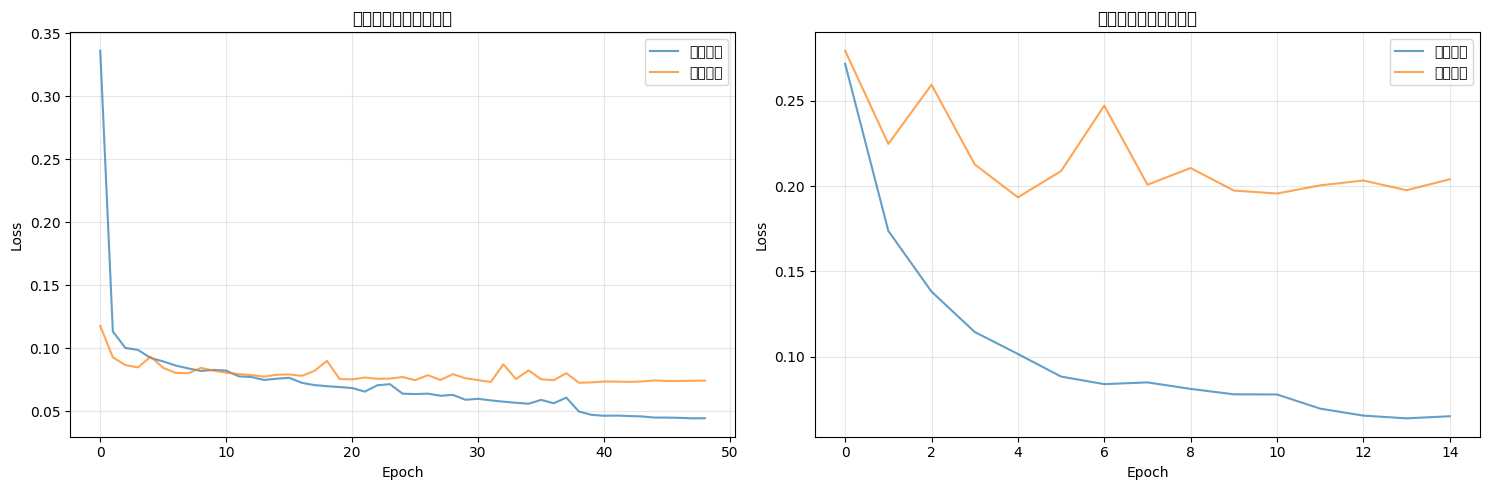


训练完成！模型和结果已保存到 model_outputs/ 目录


In [13]:
#!/usr/bin/env python3
"""
两层建模方案训练脚本
基于筛选器设计.md的第四部分要求

实现：
A. 序列聚合回归（~7k样本，总体活性预测）
B. 条件回归（~45k样本，序列×菌株细粒度预测）
"""

import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

class AMP_Dataset(Dataset):
    """AMP数据集类"""
    def __init__(self, features_dict, scaler=None, fit_scaler=False):
        """
        初始化数据集
        
        Args:
            features_dict: 特征字典
            scaler: 标准化器
            fit_scaler: 是否拟合标准化器
        """
        self.plm_embeddings = features_dict['plm_embeddings']
        self.physicochemical_features = features_dict['physicochemical_features']
        self.targets = features_dict['targets']
        self.sequences = features_dict['sequences']
        
        # 可选字段
        self.bacteria_ids = features_dict.get('bacteria_ids', None)
        self.bacteria_names = features_dict.get('bacteria_names', None)
        self.is_censored = features_dict.get('is_censored', None)
        self.censoring_threshold = features_dict.get('censoring_threshold', None)
        self.sample_weights = features_dict.get('sample_weights', None)
        
        # 标准化理化特征
        if scaler is None:
            self.scaler = StandardScaler()
            fit_scaler = True
        else:
            self.scaler = scaler
            
        if fit_scaler:
            self.physicochemical_features_scaled = self.scaler.fit_transform(self.physicochemical_features)
        else:
            self.physicochemical_features_scaled = self.scaler.transform(self.physicochemical_features)
        
        # 合并特征
        self.combined_features = np.concatenate([
            self.plm_embeddings,
            self.physicochemical_features_scaled
        ], axis=1)
        
        print(f"数据集大小: {len(self.targets)}")
        print(f"特征维度: PLM={self.plm_embeddings.shape[1]}, 理化={self.physicochemical_features.shape[1]}")
        print(f"合并特征维度: {self.combined_features.shape[1]}")
        
        if self.bacteria_ids is not None:
            print(f"包含菌株信息: {len(np.unique(self.bacteria_ids))} 个唯一菌株")
        if self.is_censored is not None:
            censored_count = np.sum(self.is_censored)
            print(f"删失样本数: {censored_count} / {len(self.is_censored)} ({100*censored_count/len(self.is_censored):.1f}%)")
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        item = {
            'features': torch.FloatTensor(self.combined_features[idx]),
            'target': torch.FloatTensor([self.targets[idx]]),
            'sequence': self.sequences[idx]
        }
        
        if self.bacteria_ids is not None:
            item['bacteria_id'] = torch.LongTensor([self.bacteria_ids[idx]])
        
        if self.is_censored is not None:
            item['is_censored'] = torch.BoolTensor([self.is_censored[idx]])
            item['censoring_threshold'] = torch.FloatTensor([self.censoring_threshold[idx]])
        
        if self.sample_weights is not None:
            item['sample_weight'] = torch.FloatTensor([self.sample_weights[idx]])
        
        return item

class SequenceRegressionModel(nn.Module):
    """序列聚合回归模型（模型A）"""
    def __init__(self, input_dim, hidden_dims=[1024, 512], dropout=0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),  # Swish激活函数
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # 输出层
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
        # 权重初始化
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, features):
        return self.model(features).squeeze(-1)

class ConditionalRegressionModel(nn.Module):
    """条件回归模型（模型B）"""
    def __init__(self, input_dim, n_bacteria, bacteria_embedding_dim=32, 
                 hidden_dims=[1024, 512], dropout=0.3):
        super().__init__()
        
        # 菌株embedding层
        self.bacteria_embedding = nn.Embedding(n_bacteria, bacteria_embedding_dim)
        
        # 合并输入维度
        combined_input_dim = input_dim + bacteria_embedding_dim
        
        layers = []
        prev_dim = combined_input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # 输出层
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
        
        # 权重初始化
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.1)
    
    def forward(self, features, bacteria_ids):
        # 获取菌株embedding
        bacteria_emb = self.bacteria_embedding(bacteria_ids.squeeze(-1))
        
        # 拼接特征
        combined = torch.cat([features, bacteria_emb], dim=-1)
        
        return self.model(combined).squeeze(-1)

class HuberLoss(nn.Module):
    """Huber损失函数"""
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta
    
    def forward(self, pred, target):
        abs_error = torch.abs(pred - target)
        quadratic = torch.clamp(abs_error, max=self.delta)
        linear = abs_error - quadratic
        return torch.mean(0.5 * quadratic**2 + self.delta * linear)

class CensoringAwareHuberLoss(nn.Module):
    """删失感知的Huber损失"""
    def __init__(self, delta=1.0, censoring_weight=2.0):
        super().__init__()
        self.delta = delta
        self.censoring_weight = censoring_weight
        self.huber = HuberLoss(delta)
    
    def forward(self, pred, target, is_censored=None, censoring_threshold=None):
        if is_censored is None:
            # 没有删失信息，使用标准Huber损失
            return self.huber(pred, target)
        
        # 非删失样本的损失
        uncensored_mask = ~is_censored
        uncensored_loss = 0.0
        if uncensored_mask.sum() > 0:
            uncensored_loss = self.huber(pred[uncensored_mask], target[uncensored_mask])
        
        # 删失样本的损失（右删失）
        censored_mask = is_censored
        censored_loss = 0.0
        if censored_mask.sum() > 0:
            # 只有当预测值小于删失阈值时才惩罚
            censored_pred = pred[censored_mask]
            censored_thresh = censoring_threshold[censored_mask]
            violation = torch.clamp(censored_thresh - censored_pred, min=0)
            censored_loss = torch.mean(violation ** 2) * self.censoring_weight
        
        # 加权组合
        n_uncensored = uncensored_mask.sum().float()
        n_censored = censored_mask.sum().float()
        n_total = len(pred)
        
        if n_uncensored > 0 and n_censored > 0:
            total_loss = (n_uncensored / n_total) * uncensored_loss + (n_censored / n_total) * censored_loss
        elif n_uncensored > 0:
            total_loss = uncensored_loss
        else:
            total_loss = censored_loss
        
        return total_loss

class AMPTrainer:
    """AMP模型训练器"""
    def __init__(self, device='auto', output_dir='model_outputs'):
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"使用设备: {self.device}")
    
    def load_data(self, features_dir='features'):
        """加载特征数据"""
        print("正在加载特征数据...")
        
        self.datasets = {}
        self.scalers = {}
        
        # 加载序列聚合数据集
        for split in ['train', 'val', 'test']:
            file_path = os.path.join(features_dir, f'sequence_{split}_features.pkl')
            if os.path.exists(file_path):
                with open(file_path, 'rb') as f:
                    features_dict = pickle.load(f)
                
                # 第一个数据集拟合scaler
                if f'sequence_{split}' not in self.scalers:
                    if split == 'train':
                        dataset = AMP_Dataset(features_dict, fit_scaler=True)
                        self.scalers['sequence'] = dataset.scaler
                    else:
                        dataset = AMP_Dataset(features_dict, scaler=self.scalers['sequence'])
                else:
                    dataset = AMP_Dataset(features_dict, scaler=self.scalers['sequence'])
                
                self.datasets[f'sequence_{split}'] = dataset
                print(f"加载序列数据集 {split}: {len(dataset)} 样本")
        
        # 加载条件回归数据集
        for split in ['train', 'val', 'test']:
            file_path = os.path.join(features_dir, f'conditional_{split}_features.pkl')
            if os.path.exists(file_path):
                with open(file_path, 'rb') as f:
                    features_dict = pickle.load(f)
                
                if f'conditional_{split}' not in self.scalers:
                    if split == 'train':
                        dataset = AMP_Dataset(features_dict, fit_scaler=True)
                        self.scalers['conditional'] = dataset.scaler
                    else:
                        dataset = AMP_Dataset(features_dict, scaler=self.scalers['conditional'])
                else:
                    dataset = AMP_Dataset(features_dict, scaler=self.scalers['conditional'])
                
                self.datasets[f'conditional_{split}'] = dataset
                print(f"加载条件数据集 {split}: {len(dataset)} 样本")
        
        # 加载菌株映射
        bacteria_mapping_file = os.path.join(features_dir, 'bacteria_mapping.pkl')
        with open(bacteria_mapping_file, 'rb') as f:
            self.bacteria_mapping = pickle.load(f)
        
        print(f"菌株数量: {len(self.bacteria_mapping['bacteria_to_id'])}")
    
    def train_sequence_model(self, batch_size=128, learning_rate=2e-4, 
                           num_epochs=100, patience=10):
        """训练序列聚合回归模型"""
        print("\n=== 训练序列聚合回归模型 ===")
        
        train_dataset = self.datasets['sequence_train']
        val_dataset = self.datasets['sequence_val']
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # 创建模型
        input_dim = train_dataset.combined_features.shape[1]
        model = SequenceRegressionModel(input_dim=input_dim).to(self.device)
        
        # 优化器和损失函数
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
        criterion = HuberLoss(delta=1.0)
        
        # 训练循环
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # 训练阶段
            model.train()
            train_loss = 0.0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                features = batch['features'].to(self.device)
                targets = batch['target'].squeeze(-1).to(self.device)
                
                optimizer.zero_grad()
                predictions = model(features)
                loss = criterion(predictions, targets)
                loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            
            # 验证阶段
            model.eval()
            val_loss = 0.0
            val_predictions = []
            val_targets = []
            
            with torch.no_grad():
                for batch in val_loader:
                    features = batch['features'].to(self.device)
                    targets = batch['target'].squeeze(-1).to(self.device)
                    
                    predictions = model(features)
                    loss = criterion(predictions, targets)
                    val_loss += loss.item()
                    
                    val_predictions.extend(predictions.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())
            
            val_loss /= len(val_loader)
            
            # 计算评估指标
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            val_r2 = r2_score(val_targets, val_predictions)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f}")
            
            # 学习率调度
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # 保存最佳模型
                torch.save(model.state_dict(), 
                          os.path.join(self.output_dir, 'sequence_regression_best.pt'))
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停在第 {epoch+1} 轮")
                    break
        
        # 保存训练历史
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }
        
        with open(os.path.join(self.output_dir, 'sequence_training_history.pkl'), 'wb') as f:
            pickle.dump(history, f)
        
        # 加载最佳模型进行测试
        model.load_state_dict(torch.load(os.path.join(self.output_dir, 'sequence_regression_best.pt')))
        self.sequence_model = model
        
        # 在测试集上评估
        self.evaluate_sequence_model()
        
        return model, history
    
    def train_conditional_model(self, batch_size=128, learning_rate=2e-4,
                              num_epochs=100, patience=10):
        """训练条件回归模型"""
        print("\n=== 训练条件回归模型 ===")
        
        train_dataset = self.datasets['conditional_train']
        val_dataset = self.datasets['conditional_val']
        
        # 创建加权采样器（平衡菌株分布）
        bacteria_counts = np.bincount(train_dataset.bacteria_ids.flatten())
        bacteria_weights = 1.0 / np.sqrt(bacteria_counts + 1e-8)  # 避免除零
        sample_weights = bacteria_weights[train_dataset.bacteria_ids.flatten()]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # 创建模型
        input_dim = train_dataset.combined_features.shape[1]
        n_bacteria = len(self.bacteria_mapping['bacteria_to_id'])
        model = ConditionalRegressionModel(
            input_dim=input_dim,
            n_bacteria=n_bacteria,
            bacteria_embedding_dim=32
        ).to(self.device)
        
        # 优化器和损失函数
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
        criterion = CensoringAwareHuberLoss(delta=1.0, censoring_weight=2.0)
        
        # 训练循环
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # 训练阶段
            model.train()
            train_loss = 0.0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                features = batch['features'].to(self.device)
                bacteria_ids = batch['bacteria_id'].to(self.device)
                targets = batch['target'].squeeze(-1).to(self.device)
                is_censored = batch['is_censored'].squeeze(-1).to(self.device)
                censoring_threshold = batch['censoring_threshold'].squeeze(-1).to(self.device)
                
                optimizer.zero_grad()
                predictions = model(features, bacteria_ids)
                loss = criterion(predictions, targets, is_censored, censoring_threshold)
                loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            
            # 验证阶段
            model.eval()
            val_loss = 0.0
            val_predictions = []
            val_targets = []
            
            with torch.no_grad():
                for batch in val_loader:
                    features = batch['features'].to(self.device)
                    bacteria_ids = batch['bacteria_id'].to(self.device)
                    targets = batch['target'].squeeze(-1).to(self.device)
                    is_censored = batch['is_censored'].squeeze(-1).to(self.device)
                    censoring_threshold = batch['censoring_threshold'].squeeze(-1).to(self.device)
                    
                    predictions = model(features, bacteria_ids)
                    loss = criterion(predictions, targets, is_censored, censoring_threshold)
                    val_loss += loss.item()
                    
                    val_predictions.extend(predictions.cpu().numpy())
                    val_targets.extend(targets.cpu().numpy())
            
            val_loss /= len(val_loader)
            
            # 计算评估指标
            val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
            val_r2 = r2_score(val_targets, val_predictions)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
                  f"Val RMSE={val_rmse:.4f}, Val R²={val_r2:.4f}")
            
            # 学习率调度
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # 保存最佳模型
                torch.save(model.state_dict(), 
                          os.path.join(self.output_dir, 'conditional_regression_best.pt'))
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停在第 {epoch+1} 轮")
                    break
        
        # 保存训练历史
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }
        
        with open(os.path.join(self.output_dir, 'conditional_training_history.pkl'), 'wb') as f:
            pickle.dump(history, f)
        
        # 加载最佳模型进行测试
        model.load_state_dict(torch.load(os.path.join(self.output_dir, 'conditional_regression_best.pt')))
        self.conditional_model = model
        
        # 在测试集上评估
        self.evaluate_conditional_model()
        
        return model, history
    
    def evaluate_sequence_model(self):
        """评估序列聚合模型"""
        print("\n=== 评估序列聚合模型 ===")
        
        test_dataset = self.datasets['sequence_test']
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        self.sequence_model.eval()
        predictions = []
        targets = []
        
        with torch.no_grad():
            for batch in test_loader:
                features = batch['features'].to(self.device)
                batch_targets = batch['target'].squeeze(-1).to(self.device)
                
                batch_predictions = self.sequence_model(features)
                
                predictions.extend(batch_predictions.cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())
        
        # 计算回归指标
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        r2 = r2_score(targets, predictions)
        
        print(f"测试集 RMSE: {rmse:.4f}")
        print(f"测试集 R²: {r2:.4f}")
        
        # 计算二分类指标（不同阈值）
        thresholds = {
            '2μM': np.log10(2),    # ≈ 0.301
            '5μM': np.log10(5),    # ≈ 0.699  
            '10μM': np.log10(10)   # = 1.0
        }
        
        for name, threshold in thresholds.items():
            y_true = (np.array(targets) <= threshold).astype(int)
            y_scores = -np.array(predictions)  # 负号：越小的预测值越可能是活性的
            
            if len(np.unique(y_true)) == 2:  # 确保有两个类别
                auc = roc_auc_score(y_true, y_scores)
                ap = average_precision_score(y_true, y_scores)
                print(f"{name} 阈值 - AUC: {auc:.4f}, AP: {ap:.4f}")
        
        # 保存预测结果
        results = {
            'predictions': predictions,
            'targets': targets,
            'rmse': rmse,
            'r2': r2
        }
        
        with open(os.path.join(self.output_dir, 'sequence_test_results.pkl'), 'wb') as f:
            pickle.dump(results, f)
        
        return results
    
    def evaluate_conditional_model(self):
        """评估条件回归模型"""
        print("\n=== 评估条件回归模型 ===")
        
        test_dataset = self.datasets['conditional_test']
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        self.conditional_model.eval()
        predictions = []
        targets = []
        bacteria_ids = []
        
        with torch.no_grad():
            for batch in test_loader:
                features = batch['features'].to(self.device)
                batch_bacteria_ids = batch['bacteria_id'].to(self.device)
                batch_targets = batch['target'].squeeze(-1).to(self.device)
                
                batch_predictions = self.conditional_model(features, batch_bacteria_ids)
                
                predictions.extend(batch_predictions.cpu().numpy())
                targets.extend(batch_targets.cpu().numpy())
                bacteria_ids.extend(batch_bacteria_ids.squeeze(-1).cpu().numpy())
        
        # 整体指标
        rmse = np.sqrt(mean_squared_error(targets, predictions))
        r2 = r2_score(targets, predictions)
        
        print(f"整体测试集 RMSE: {rmse:.4f}")
        print(f"整体测试集 R²: {r2:.4f}")
        
        # 按菌株评估
        unique_bacteria = np.unique(bacteria_ids)
        bacteria_results = {}
        
        for bacteria_id in unique_bacteria:
            mask = np.array(bacteria_ids) == bacteria_id
            if mask.sum() >= 10:  # 至少10个样本
                bacteria_pred = np.array(predictions)[mask]
                bacteria_target = np.array(targets)[mask]
                
                bacteria_rmse = np.sqrt(mean_squared_error(bacteria_target, bacteria_pred))
                bacteria_r2 = r2_score(bacteria_target, bacteria_pred)
                
                bacteria_name = self.bacteria_mapping['id_to_bacteria'][bacteria_id]
                bacteria_results[bacteria_name] = {
                    'rmse': bacteria_rmse,
                    'r2': bacteria_r2,
                    'n_samples': mask.sum()
                }
        
        # 显示Top 10菌株结果
        print("\nTop 10 菌株结果:")
        sorted_bacteria = sorted(bacteria_results.items(), 
                               key=lambda x: x[1]['n_samples'], reverse=True)
        
        for bacteria_name, results in sorted_bacteria[:10]:
            print(f"{bacteria_name}: RMSE={results['rmse']:.4f}, "
                  f"R²={results['r2']:.4f}, N={results['n_samples']}")
        
        # 计算二分类指标
        thresholds = {
            '2μM': np.log10(2),
            '5μM': np.log10(5),
            '10μM': np.log10(10)
        }
        
        for name, threshold in thresholds.items():
            y_true = (np.array(targets) <= threshold).astype(int)
            y_scores = -np.array(predictions)
            
            if len(np.unique(y_true)) == 2:
                auc = roc_auc_score(y_true, y_scores)
                ap = average_precision_score(y_true, y_scores)
                print(f"{name} 阈值 - AUC: {auc:.4f}, AP: {ap:.4f}")
        
        # 保存结果
        results = {
            'predictions': predictions,
            'targets': targets,
            'bacteria_ids': bacteria_ids,
            'rmse': rmse,
            'r2': r2,
            'bacteria_results': bacteria_results
        }
        
        with open(os.path.join(self.output_dir, 'conditional_test_results.pkl'), 'wb') as f:
            pickle.dump(results, f)
        
        return results
    
    def plot_training_curves(self):
        """绘制训练曲线"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # 序列模型训练曲线
        if os.path.exists(os.path.join(self.output_dir, 'sequence_training_history.pkl')):
            with open(os.path.join(self.output_dir, 'sequence_training_history.pkl'), 'rb') as f:
                seq_history = pickle.load(f)
            
            axes[0].plot(seq_history['train_losses'], label='训练损失', alpha=0.7)
            axes[0].plot(seq_history['val_losses'], label='验证损失', alpha=0.7)
            axes[0].set_title('序列聚合模型训练曲线')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
        
        # 条件模型训练曲线
        if os.path.exists(os.path.join(self.output_dir, 'conditional_training_history.pkl')):
            with open(os.path.join(self.output_dir, 'conditional_training_history.pkl'), 'rb') as f:
                cond_history = pickle.load(f)
            
            axes[1].plot(cond_history['train_losses'], label='训练损失', alpha=0.7)
            axes[1].plot(cond_history['val_losses'], label='验证损失', alpha=0.7)
            axes[1].set_title('条件回归模型训练曲线')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
        plt.show()

def main():
    """主函数"""
    # 创建训练器
    trainer = AMPTrainer(device='auto', output_dir='/root/NKU-TMU_AMP_project/model_outputs')
    
    # 加载数据
    trainer.load_data(features_dir='/root/NKU-TMU_AMP_project/features')
    
    # 训练序列聚合模型
    print("\n" + "="*50)
    print("开始训练序列聚合回归模型")
    print("="*50)
    
    sequence_model, seq_history = trainer.train_sequence_model(
        batch_size=128,
        learning_rate=2e-4,
        num_epochs=100,
        patience=10
    )
    
    # 训练条件回归模型
    print("\n" + "="*50)
    print("开始训练条件回归模型")
    print("="*50)
    
    conditional_model, cond_history = trainer.train_conditional_model(
        batch_size=128,
        learning_rate=2e-4,
        num_epochs=100,
        patience=10
    )
    
    # 绘制训练曲线
    trainer.plot_training_curves()
    
    print("\n" + "="*50)
    print("训练完成！模型和结果已保存到 model_outputs/ 目录")
    print("="*50)

if __name__ == "__main__":
    main()


AMP判别器两层建模训练
批次大小: 128
学习率: 0.0002
训练轮数: 100
早停patience: 10
设备: auto
特征目录: /root/.local/share/jupyter/runtime/kernel-v3f699397a0edb8b92a8a3a385e54e41119e4d6f86.json
输出目录: /root/NKU-TMU_AMP_project/model_outputs
使用设备: cuda

步骤1: 加载特征数据
正在加载特征数据...


NotADirectoryError: [Errno 20] Not a directory: '/root/.local/share/jupyter/runtime/kernel-v3f699397a0edb8b92a8a3a385e54e41119e4d6f86.json/bacteria_mapping.pkl'

In [ ]:
#!/usr/bin/env python3
"""
双头模型训练脚本 - 专注于E.coli和S.aureus
基于共享骨干网络 + 两个独立输出头的架构
"""

import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# 导入数据预处理和特征工程模块
sys.path.append('/root/NKU-TMU_AMP_project')
from data_preprocessing import GRAMPAPreprocessor
from feature_engineering import AMP_FeatureExtractor

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

class DualHeadDataset(Dataset):
    """双头模型数据集类"""
    def __init__(self, features_dict, bacteria_mapping, scaler=None, fit_scaler=False):
        """
        初始化数据集
        
        Args:
            features_dict: 特征字典
            bacteria_mapping: 菌株映射 {'escherichia_coli': 0, 'staphylococcus_aureus': 1}
            scaler: 标准化器
            fit_scaler: 是否拟合标准化器
        """
        self.plm_embeddings = features_dict['plm_embeddings']
        self.physicochemical_features = features_dict['physicochemical_features']
        self.targets = features_dict['targets']
        self.bacteria_names = features_dict['bacteria_names']
        self.sequences = features_dict['sequences']
        
        # 可选字段
        self.is_censored = features_dict.get('is_censored', None)
        self.censoring_threshold = features_dict.get('censoring_threshold', None)
        self.sample_weights = features_dict.get('sample_weights', None)
        
        # 菌株ID映射
        self.bacteria_mapping = bacteria_mapping
        self.bacteria_ids = np.array([bacteria_mapping[name] for name in self.bacteria_names])
        
        # 标准化理化特征
        if scaler is None:
            self.scaler = StandardScaler()
            fit_scaler = True
        else:
            self.scaler = scaler
            
        if fit_scaler:
            self.physicochemical_features_scaled = self.scaler.fit_transform(self.physicochemical_features)
        else:
            self.physicochemical_features_scaled = self.scaler.transform(self.physicochemical_features)
        
        # 合并特征
        self.combined_features = np.concatenate([
            self.plm_embeddings,
            self.physicochemical_features_scaled
        ], axis=1)
        
        print(f"数据集大小: {len(self.targets)}")
        print(f"特征维度: PLM={self.plm_embeddings.shape[1]}, 理化={self.physicochemical_features.shape[1]}")
        print(f"合并特征维度: {self.combined_features.shape[1]}")
        
        # 统计菌株分布
        bacteria_counts = pd.Series(self.bacteria_names).value_counts()
        print("菌株分布:")
        for bacteria, count in bacteria_counts.items():
            print(f"  {bacteria}: {count} ({100*count/len(self.bacteria_names):.1f}%)")
        
        if self.is_censored is not None:
            censored_count = np.sum(self.is_censored)
            print(f"删失样本数: {censored_count} / {len(self.is_censored)} ({100*censored_count/len(self.is_censored):.1f}%)")
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        item = {
            'features': torch.FloatTensor(self.combined_features[idx]),
            'target': torch.FloatTensor([self.targets[idx]]),
            'bacteria_id': torch.LongTensor([self.bacteria_ids[idx]]),
            'bacteria_name': self.bacteria_names[idx],
            'sequence': self.sequences[idx]
        }
        
        if self.is_censored is not None:
            item['is_censored'] = torch.BoolTensor([self.is_censored[idx]])
            item['censoring_threshold'] = torch.FloatTensor([self.censoring_threshold[idx]])
        
        if self.sample_weights is not None:
            item['sample_weight'] = torch.FloatTensor([self.sample_weights[idx]])
        
        return item

class DualHeadModel(nn.Module):
    """双头模型：共享骨干 + 两个独立输出头"""
    def __init__(self, input_dim, hidden_dims=[512, 256], dropout=0.2):
        super().__init__()
        
        # 共享骨干网络
        backbone_layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            backbone_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),  # Swish激活函数
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.backbone = nn.Sequential(*backbone_layers)
        
        # 两个独立的输出头
        self.head_ecoli = nn.Linear(prev_dim, 1)      # Head₀: E.coli
        self.head_saureus = nn.Linear(prev_dim, 1)    # Head₁: S.aureus
        
        # 权重初始化
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
    
    def forward(self, features):
        # 共享骨干
        shared_features = self.backbone(features)
        
        # 两个独立输出头
        pred_ecoli = self.head_ecoli(shared_features).squeeze(-1)
        pred_saureus = self.head_saureus(shared_features).squeeze(-1)
        
        return pred_ecoli, pred_saureus

class DualHeadLoss(nn.Module):
    """双头模型的损失函数（删失感知 + 稳健）"""
    def __init__(self, delta=1.0, censoring_weight=1.0):
        super().__init__()
        self.delta = delta
        self.censoring_weight = censoring_weight
    
    def huber_loss(self, pred, target):
        """Huber损失"""
        abs_error = torch.abs(pred - target)
        quadratic = torch.clamp(abs_error, max=self.delta)
        linear = abs_error - quadratic
        return 0.5 * quadratic**2 + self.delta * linear
    
    def forward(self, pred_ecoli, pred_saureus, targets, bacteria_ids, 
                is_censored=None, censoring_threshold=None):
        """
        计算双头损失
        
        Args:
            pred_ecoli: E.coli预测值 (batch_size,)
            pred_saureus: S.aureus预测值 (batch_size,)
            targets: 真实值 (batch_size,)
            bacteria_ids: 菌株ID (batch_size,) - 0: E.coli, 1: S.aureus
            is_censored: 删失标记 (batch_size,)
            censoring_threshold: 删失阈值 (batch_size,)
        """
        batch_size = len(targets)
        total_loss = 0.0
        valid_samples = 0
        
        for i in range(batch_size):
            bacteria_id = bacteria_ids[i].item()
            target = targets[i]
            
            # 根据菌株ID选择对应的预测头
            if bacteria_id == 0:  # E.coli
                pred = pred_ecoli[i]
            else:  # S.aureus
                pred = pred_saureus[i]
            
            # 计算该样本的损失
            if is_censored is not None and is_censored[i]:
                # 删失样本：右删失约束
                threshold = censoring_threshold[i]
                censored_loss = torch.clamp(threshold - pred, min=0) ** 2
                sample_loss = self.censoring_weight * censored_loss
            else:
                # 非删失样本：Huber损失
                sample_loss = self.huber_loss(pred, target)
            
            total_loss += sample_loss
            valid_samples += 1
        
        return total_loss / valid_samples if valid_samples > 0 else torch.tensor(0.0)

class DualHeadTrainer:
    """双头模型训练器"""
    def __init__(self, device='auto', output_dir='model_outputs'):
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"使用设备: {self.device}")
        
        # 菌株映射
        self.bacteria_mapping = {
            'escherichia_coli': 0,
            'staphylococcus_aureus': 1
        }
        self.id_to_bacteria = {0: 'escherichia_coli', 1: 'staphylococcus_aureus'}
    
    def prepare_data(self, input_file='/root/NKU-TMU_AMP_project/data/AMP/grampa_merged_dataset.csv'):
        """准备双头模型数据"""
        print("=== 步骤1: 数据预处理（仅保留E.coli和S.aureus）===")
        
        # 使用数据预处理器
        preprocessor = GRAMPAPreprocessor(
            input_file=input_file,
            output_dir='/root/NKU-TMU_AMP_project/processed_data'
        )
        
        # 运行预处理流程
        preprocessor.run_full_pipeline()
        
        # 加载聚合数据
        aggregated_df = pd.read_csv('/root/NKU-TMU_AMP_project/processed_data/grampa_aggregated_full.csv')
        
        # 过滤只保留两个目标菌株
        target_bacteria = ['escherichia_coli', 'staphylococcus_aureus']
        filtered_df = aggregated_df[aggregated_df['bacterium'].isin(target_bacteria)].copy()
        
        print(f"原始聚合数据: {len(aggregated_df)} 样本")
        print(f"过滤后数据: {len(filtered_df)} 样本")
        
        # 统计过滤后的菌株分布
        bacteria_counts = filtered_df['bacterium'].value_counts()
        print("过滤后菌株分布:")
        for bacteria, count in bacteria_counts.items():
            print(f"  {bacteria}: {count}")
        
        # 保存过滤后的数据集
        for split in ['train', 'val', 'test']:
            split_df = filtered_df[filtered_df['split'] == split].copy()
            if len(split_df) > 0:
                output_file = f'/root/NKU-TMU_AMP_project/processed_data/grampa_conditional_{split}_top2.csv'
                split_df.to_csv(output_file, index=False)
                print(f"保存 {split} 集: {output_file} ({len(split_df)} 样本)")
        
        return filtered_df
    
    def extract_features(self):
        """提取特征"""
        print("\n=== 步骤2: 特征提取 ===")
        
        # 使用特征提取器
        extractor = AMP_FeatureExtractor(
            processed_data_dir='/root/NKU-TMU_AMP_project/processed_data',
            features_output_dir='/root/NKU-TMU_AMP_project/features',
            device=self.device
        )
        
        # 为双头数据集提取特征
        datasets = {}
        for split in ['train', 'val', 'test']:
            file_path = f'/root/NKU-TMU_AMP_project/processed_data/grampa_conditional_{split}_top2.csv'
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                
                # 收集唯一序列
                sequences = df['sequence'].unique()
                
                # 提取PLM embeddings
                plm_embeddings = extractor.extract_plm_embeddings(sequences.tolist())
                
                # 提取理化特征
                physchem_features = extractor.calculate_physicochemical_features(sequences.tolist())
                
                # 标准化理化特征
                if split == 'train':
                    scaler = StandardScaler()
                    physchem_features_scaled = scaler.fit_transform(physchem_features)
                    self.scaler = scaler
                else:
                    physchem_features_scaled = self.scaler.transform(physchem_features)
                
                # 创建序列到特征的映射
                seq_to_plm = {seq: plm_embeddings[i] for i, seq in enumerate(sequences)}
                seq_to_physchem = {seq: physchem_features_scaled[i] for i, seq in enumerate(sequences)}
                
                # 为数据集中的每个样本分配特征
                dataset_plm = np.array([seq_to_plm[seq] for seq in df['sequence']])
                dataset_physchem = np.array([seq_to_physchem[seq] for seq in df['sequence']])
                
                # 构建特征字典
                features_dict = {
                    'plm_embeddings': dataset_plm,
                    'physicochemical_features': dataset_physchem,
                    'sequences': df['sequence'].values,
                    'bacteria_names': df['bacterium'].values,
                    'targets': df['value_winsorized'].values,
                    'is_censored': df['is_censored'].values,
                    'censoring_threshold': df['censoring_threshold'].fillna(0).values,
                    'sample_weights': df['n_measurements'].values
                }
                
                # 保存特征文件
                output_file = f'/root/NKU-TMU_AMP_project/features/dual_head_{split}_features.pkl'
                with open(output_file, 'wb') as f:
                    pickle.dump(features_dict, f)
                
                datasets[split] = features_dict
                print(f"{split}集特征提取完成: PLM {dataset_plm.shape}, 理化 {dataset_physchem.shape}")
        
        return datasets
    
    def create_datasets(self, features_data):
        """创建PyTorch数据集"""
        print("\n=== 步骤3: 创建PyTorch数据集 ===")
        
        datasets = {}
        
        # 训练集
        train_dataset = DualHeadDataset(
            features_data['train'], 
            self.bacteria_mapping,
            fit_scaler=True
        )
        datasets['train'] = train_dataset
        self.scaler = train_dataset.scaler
        
        # 验证集和测试集
        for split in ['val', 'test']:
            if split in features_data:
                dataset = DualHeadDataset(
                    features_data[split],
                    self.bacteria_mapping,
                    scaler=self.scaler
                )
                datasets[split] = dataset
        
        return datasets
    
    def train_model(self, datasets, batch_size=128, learning_rate=1e-4, 
                   num_epochs=100, patience=15):
        """训练双头模型"""
        print("\n=== 步骤4: 训练双头模型 ===")
        
        train_dataset = datasets['train']
        val_dataset = datasets['val']
        
        # 创建平衡采样器
        bacteria_ids = train_dataset.bacteria_ids
        bacteria_counts = np.bincount(bacteria_ids)
        bacteria_weights = 1.0 / np.sqrt(bacteria_counts + 1e-8)
        sample_weights = bacteria_weights[bacteria_ids]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # 创建模型
        input_dim = train_dataset.combined_features.shape[1]
        model = DualHeadModel(input_dim=input_dim, hidden_dims=[512, 256], dropout=0.2).to(self.device)
        
        # 优化器和损失函数
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
        criterion = DualHeadLoss(delta=1.0, censoring_weight=1.0)
        
        # 训练循环
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            # 训练阶段
            model.train()
            train_loss = 0.0
            
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                features = batch['features'].to(self.device)
                targets = batch['target'].squeeze(-1).to(self.device)
                bacteria_ids = batch['bacteria_id'].squeeze(-1).to(self.device)
                is_censored = batch['is_censored'].squeeze(-1).to(self.device)
                censoring_threshold = batch['censoring_threshold'].squeeze(-1).to(self.device)
                
                optimizer.zero_grad()
                pred_ecoli, pred_saureus = model(features)
                loss = criterion(pred_ecoli, pred_saureus, targets, bacteria_ids, 
                               is_censored, censoring_threshold)
                loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            
            # 验证阶段
            model.eval()
            val_loss = 0.0
            val_predictions = {0: [], 1: []}  # 分菌株记录预测
            val_targets = {0: [], 1: []}
            
            with torch.no_grad():
                for batch in val_loader:
                    features = batch['features'].to(self.device)
                    targets = batch['target'].squeeze(-1).to(self.device)
                    bacteria_ids = batch['bacteria_id'].squeeze(-1).to(self.device)
                    is_censored = batch['is_censored'].squeeze(-1).to(self.device)
                    censoring_threshold = batch['censoring_threshold'].squeeze(-1).to(self.device)
                    
                    pred_ecoli, pred_saureus = model(features)
                    loss = criterion(pred_ecoli, pred_saureus, targets, bacteria_ids,
                                   is_censored, censoring_threshold)
                    val_loss += loss.item()
                    
                    # 分菌株记录预测结果
                    for i in range(len(targets)):
                        bacteria_id = bacteria_ids[i].item()
                        target = targets[i].item()
                        
                        if bacteria_id == 0:
                            pred = pred_ecoli[i].item()
                        else:
                            pred = pred_saureus[i].item()
                        
                        val_predictions[bacteria_id].append(pred)
                        val_targets[bacteria_id].append(target)
            
            val_loss /= len(val_loader)
            
            # 计算分菌株评估指标
            val_metrics = {}
            for bacteria_id in [0, 1]:
                if len(val_targets[bacteria_id]) > 0:
                    preds = np.array(val_predictions[bacteria_id])
                    targs = np.array(val_targets[bacteria_id])
                    rmse = np.sqrt(mean_squared_error(targs, preds))
                    r2 = r2_score(targs, preds)
                    val_metrics[self.id_to_bacteria[bacteria_id]] = {'rmse': rmse, 'r2': r2}
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            # 打印进度
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
            for bacteria_name, metrics in val_metrics.items():
                print(f"  {bacteria_name}: RMSE={metrics['rmse']:.4f}, R²={metrics['r2']:.4f}")
            
            # 学习率调度
            scheduler.step(val_loss)
            
            # 早停
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # 保存最佳模型
                torch.save(model.state_dict(), 
                          os.path.join(self.output_dir, 'dual_head_best.pt'))
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"早停在第 {epoch+1} 轮")
                    break
        
        # 保存训练历史
        history = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss
        }
        
        with open(os.path.join(self.output_dir, 'dual_head_training_history.pkl'), 'wb') as f:
            pickle.dump(history, f)
        
        # 加载最佳模型
        model.load_state_dict(torch.load(os.path.join(self.output_dir, 'dual_head_best.pt')))
        self.model = model
        
        return model, history
    
    def evaluate_model(self, datasets):
        """评估模型"""
        print("\n=== 步骤5: 模型评估 ===")
        
        test_dataset = datasets['test']
        test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
        
        self.model.eval()
        predictions = {0: [], 1: []}
        targets = {0: [], 1: []}
        
        with torch.no_grad():
            for batch in test_loader:
                features = batch['features'].to(self.device)
                batch_targets = batch['target'].squeeze(-1).to(self.device)
                bacteria_ids = batch['bacteria_id'].squeeze(-1).to(self.device)
                
                pred_ecoli, pred_saureus = self.model(features)
                
                # 分菌株记录结果
                for i in range(len(batch_targets)):
                    bacteria_id = bacteria_ids[i].item()
                    target = batch_targets[i].item()
                    
                    if bacteria_id == 0:
                        pred = pred_ecoli[i].item()
                    else:
                        pred = pred_saureus[i].item()
                    
                    predictions[bacteria_id].append(pred)
                    targets[bacteria_id].append(target)
        
        # 计算评估指标
        results = {}
        for bacteria_id in [0, 1]:
            bacteria_name = self.id_to_bacteria[bacteria_id]
            preds = np.array(predictions[bacteria_id])
            targs = np.array(targets[bacteria_id])
            
            if len(targs) > 0:
                rmse = np.sqrt(mean_squared_error(targs, preds))
                r2 = r2_score(targs, preds)
                
                # 计算二分类指标
                thresholds = {'2μM': np.log10(2), '5μM': np.log10(5), '10μM': np.log10(10)}
                binary_metrics = {}
                
                for name, threshold in thresholds.items():
                    y_true = (targs <= threshold).astype(int)
                    y_scores = -preds  # 负号：越小的预测值越可能是活性的
                    
                    if len(np.unique(y_true)) == 2:
                        auc = roc_auc_score(y_true, y_scores)
                        ap = average_precision_score(y_true, y_scores)
                        binary_metrics[name] = {'auc': auc, 'ap': ap}
                
                results[bacteria_name] = {
                    'rmse': rmse,
                    'r2': r2,
                    'n_samples': len(targs),
                    'predictions': preds,
                    'targets': targs,
                    'binary_metrics': binary_metrics
                }
                
                print(f"{bacteria_name} 测试结果:")
                print(f"  样本数: {len(targs)}")
                print(f"  RMSE: {rmse:.4f}")
                print(f"  R²: {r2:.4f}")
                
                for name, metrics in binary_metrics.items():
                    print(f"  {name} - AUC: {metrics['auc']:.4f}, AP: {metrics['ap']:.4f}")
        
        # 保存结果
        with open(os.path.join(self.output_dir, 'dual_head_test_results.pkl'), 'wb') as f:
            pickle.dump(results, f)
        
        return results
    
    def plot_results(self, history, test_results):
        """绘制结果图"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 训练曲线
        axes[0, 0].plot(history['train_losses'], label='训练损失', alpha=0.7)
        axes[0, 0].plot(history['val_losses'], label='验证损失', alpha=0.7)
        axes[0, 0].set_title('双头模型训练曲线')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 预测vs真实值散点图
        for i, (bacteria_name, results) in enumerate(test_results.items()):
            row = (i + 1) // 2
            col = (i + 1) % 2
            
            preds = results['predictions']
            targs = results['targets']
            
            axes[row, col].scatter(targs, preds, alpha=0.6)
            axes[row, col].plot([targs.min(), targs.max()], [targs.min(), targs.max()], 'r--', alpha=0.8)
            axes[row, col].set_xlabel('真实值 (log MIC)')
            axes[row, col].set_ylabel('预测值 (log MIC)')
            axes[row, col].set_title(f'{bacteria_name}\nR²={results["r2"]:.4f}, RMSE={results["rmse"]:.4f}')
            axes[row, col].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, 'dual_head_results.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"结果图已保存: {os.path.join(self.output_dir, 'dual_head_results.png')}")
    
    def run_full_pipeline(self, input_file='/root/NKU-TMU_AMP_project/data/AMP/grampa_merged_dataset.csv'):
        """运行完整流程"""
        print("开始双头模型训练流程...")
        
        # 步骤1: 数据准备
        self.prepare_data(input_file)
        
        # 步骤2: 特征提取
        features_data = self.extract_features()
        
        # 步骤3: 创建数据集
        datasets = self.create_datasets(features_data)
        
        # 步骤4: 训练模型
        model, history = self.train_model(datasets)
        
        # 步骤5: 评估模型
        test_results = self.evaluate_model(datasets)
        
        # 步骤6: 绘制结果
        self.plot_results(history, test_results)
        
        # 生成报告
        self.generate_report(history, test_results)
        
        print(f"\n双头模型训练完成！结果保存在: {self.output_dir}")
        
        return model, history, test_results
    
    def generate_report(self, history, test_results):
        """生成训练报告"""
        report_file = os.path.join(self.output_dir, 'dual_head_report.md')
        
        with open(report_file, 'w', encoding='utf-8') as f:
            f.write("# 双头模型训练报告\n\n")
            
            f.write("## 模型架构\n")
            f.write("- 共享骨干网络: 512 → 256\n")
            f.write("- 两个独立输出头: E.coli 和 S.aureus\n")
            f.write("- 激活函数: SiLU\n")
            f.write("- 正则化: LayerNorm + Dropout(0.2)\n\n")
            
            f.write("## 训练结果\n")
            f.write(f"- 训练轮数: {len(history['train_losses'])}\n")
            f.write(f"- 最佳验证损失: {history['best_val_loss']:.4f}\n")
            f.write(f"- 最终训练损失: {history['train_losses'][-1]:.4f}\n")
            f.write(f"- 最终验证损失: {history['val_losses'][-1]:.4f}\n\n")
            
            f.write("## 测试结果\n")
            for bacteria_name, results in test_results.items():
                f.write(f"### {bacteria_name}\n")
                f.write(f"- 样本数: {results['n_samples']}\n")
                f.write(f"- RMSE: {results['rmse']:.4f}\n")
                f.write(f"- R²: {results['r2']:.4f}\n")
                
                f.write("- 二分类指标:\n")
                for threshold, metrics in results['binary_metrics'].items():
                    f.write(f"  - {threshold}: AUC={metrics['auc']:.4f}, AP={metrics['ap']:.4f}\n")
                f.write("\n")
        
        print(f"训练报告已保存: {report_file}")

def main():
    """主函数"""
    # 创建训练器
    trainer = DualHeadTrainer(
        device='auto',
        output_dir='/root/NKU-TMU_AMP_project/model_outputs'
    )
    
    # 运行完整流程
    model, history, test_results = trainer.run_full_pipeline()

if __name__ == "__main__":
    main()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
序列筛选脚本
合并两个CSV文件并应用严格的筛选规则
"""

import pandas as pd
import numpy as np
import re
from collections import Counter

def calculate_net_charge(sequence, ph=7.0):
    """
    计算序列在指定pH下的净电荷
    使用简化的pKa模型
    """
    # 氨基酸pKa值 (简化模型)
    pka_values = {
        'K': 10.5,  # Lys
        'R': 12.5,  # Arg  
        'H': 6.0,   # His
        'D': 3.9,   # Asp
        'E': 4.3,   # Glu
        'C': 8.3,   # Cys
        'Y': 10.1,  # Tyr
    }
    
    # N端和C端
    n_term_pka = 9.6
    c_term_pka = 2.3
    
    net_charge = 0.0
    
    # N端贡献 (正电荷)
    net_charge += 1 / (1 + 10**(ph - n_term_pka))
    
    # C端贡献 (负电荷)
    net_charge -= 1 / (1 + 10**(c_term_pka - ph))
    
    # 各氨基酸贡献
    for aa in sequence:
        if aa in pka_values:
            pka = pka_values[aa]
            if aa in ['K', 'R', 'H']:  # 碱性氨基酸 (正电荷)
                net_charge += 1 / (1 + 10**(ph - pka))
            else:  # 酸性氨基酸 (负电荷)
                net_charge -= 1 / (1 + 10**(pka - ph))
    
    return net_charge

def has_long_repeats(sequence, max_repeat=10):
    """
    检查序列是否有超过max_repeat的连续重复氨基酸
    """
    current_aa = sequence[0] if sequence else ''
    count = 1
    
    for i in range(1, len(sequence)):
        if sequence[i] == current_aa:
            count += 1
            if count > max_repeat:
                return True
        else:
            current_aa = sequence[i]
            count = 1
    
    return False

def calculate_kr_ratio(sequence):
    """
    计算K+R占比
    """
    if not sequence:
        return 0.0
    
    k_count = sequence.count('K')
    r_count = sequence.count('R')
    total_length = len(sequence)
    
    return (k_count + r_count) / total_length

def load_and_merge_data():
    """
    加载并合并两个CSV文件
    """
    print("正在加载数据文件...")
    
    # 读取两个文件
    df1 = pd.read_csv('/root/NKU-TMU_AMP_project/decode/full_data/decoded_optimized.csv')
    df2 = pd.read_csv('/root/NKU-TMU_AMP_project/decode/full_data/decoded_optimized2.csv')
    
    print(f"文件1包含 {len(df1)} 条序列")
    print(f"文件2包含 {len(df2)} 条序列")
    
    # 合并数据
    merged_df = pd.concat([df1, df2], ignore_index=True)
    print(f"合并后共 {len(merged_df)} 条序列")
    
    return merged_df

def load_known_sequences():
    """
    加载已知的AMP序列
    """
    try:
        final_amp_df = pd.read_csv('/root/NKU-TMU_AMP_project/data/AMP/final_AMP.csv')
        # 假设序列列名为'sequence'，如果不是需要调整
        if 'sequence' in final_amp_df.columns:
            known_sequences = set(final_amp_df['sequence'].dropna())
        elif 'Sequence' in final_amp_df.columns:
            known_sequences = set(final_amp_df['Sequence'].dropna())
        else:
            # 取第一列作为序列列
            known_sequences = set(final_amp_df.iloc[:, 0].dropna())
        
        print(f"加载了 {len(known_sequences)} 条已知AMP序列")
        return known_sequences
    except Exception as e:
        print(f"加载已知序列时出错: {e}")
        return set()

def apply_filters(df, known_sequences=None):
    """
    应用所有筛选规则
    """
    print("\n开始应用筛选规则...")
    original_count = len(df)
    
    # 确保有序列列
    sequence_col = None
    for col in ['sequence', 'Sequence', 'seq']:
        if col in df.columns:
            sequence_col = col
            break
    
    if sequence_col is None:
        # 假设第一列是序列
        sequence_col = df.columns[0]
    
    print(f"使用列 '{sequence_col}' 作为序列数据")
    
    # 1. 去除空序列
    df = df.dropna(subset=[sequence_col])
    df = df[df[sequence_col].str.len() > 0]
    print(f"去除空序列后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 2. 去除重复序列
    df = df.drop_duplicates(subset=[sequence_col])
    print(f"去除重复序列后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 3. 去除已知序列
    if known_sequences:
        mask = ~df[sequence_col].isin(known_sequences)
        df = df[mask]
        print(f"去除已知序列后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 4. 连续重复筛选
    print("应用连续重复筛选...")
    mask = ~df[sequence_col].apply(lambda x: has_long_repeats(x, max_repeat=10))
    df = df[mask]
    print(f"连续重复筛选后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 5. 净电荷筛选
    print("计算净电荷...")
    net_charges = df[sequence_col].apply(calculate_net_charge)
    mask = net_charges > 0
    df = df[mask]
    print(f"净电荷>0筛选后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 6. K+R占比筛选
    print("计算K+R占比...")
    kr_ratios = df[sequence_col].apply(calculate_kr_ratio)
    mask = kr_ratios <= 0.4
    df = df[mask]
    print(f"K+R占比≤40%筛选后: {len(df)} 条 (减少 {original_count - len(df)} 条)")
    
    # 添加统计信息列
    df['net_charge'] = df[sequence_col].apply(calculate_net_charge)
    df['kr_ratio'] = df[sequence_col].apply(calculate_kr_ratio)
    df['length'] = df[sequence_col].str.len()
    
    return df

def main():
    """
    主函数
    """
    print("=== AMP序列筛选程序 ===")
    
    # 1. 加载和合并数据
    merged_df = load_and_merge_data()
    
    # 2. 加载已知序列
    known_sequences = load_known_sequences()
    
    # 3. 应用筛选规则
    filtered_df = apply_filters(merged_df, known_sequences)
    
    # 4. 保存结果
    output_path = '/root/NKU-TMU_AMP_project/decode/filtered_candidate_sequences.csv'
    filtered_df.to_csv(output_path, index=False)
    
    print(f"\n筛选完成！")
    print(f"原始序列数: {len(merged_df)}")
    print(f"筛选后序列数: {len(filtered_df)}")
    print(f"筛选率: {len(filtered_df)/len(merged_df)*100:.1f}%")
    print(f"结果已保存到: {output_path}")
    
    # 显示一些统计信息
    if len(filtered_df) > 0:
        sequence_col = None
        for col in ['sequence', 'Sequence', 'seq']:
            if col in filtered_df.columns:
                sequence_col = col
                break
        if sequence_col is None:
            sequence_col = filtered_df.columns[0]
            
        print(f"\n统计信息:")
        print(f"序列长度范围: {filtered_df['length'].min()}-{filtered_df['length'].max()}")
        print(f"平均长度: {filtered_df['length'].mean():.1f}")
        print(f"净电荷范围: {filtered_df['net_charge'].min():.2f}-{filtered_df['net_charge'].max():.2f}")
        print(f"平均净电荷: {filtered_df['net_charge'].mean():.2f}")
        print(f"K+R占比范围: {filtered_df['kr_ratio'].min():.3f}-{filtered_df['kr_ratio'].max():.3f}")
        print(f"平均K+R占比: {filtered_df['kr_ratio'].mean():.3f}")

if __name__ == "__main__":
    main()
